# Introduction

This notebook presents our work during a project realized in the context of the <b>IEOR 4523 Data Analytics Class</b> at Columbia University.<br>
This <b>Natural Language Processing</b> project comes originally from a [Kaggle competition](https://www.kaggle.com/c/spooky-author-identification). <br>
This notebook is a cleaned-up version and has been run with less data because of processing time. You can find on the same repository the notebook used for computation (sorry this one is not clear but has all the results!).

Indeed, on the laptop we can't run the code for the entire dataframe. We needed to use the [Google Compute Engine](https://cloud.google.com/compute/?utm_source=google&utm_medium=cpc&utm_campaign=na-US-all-en-dr-skws-all-all-trial-p-dr-1003905&utm_content=text-ad-none-any-DEV_c-CRE_121499866087-ADGP_Hybrid+%7C+AW+SEM+%7C+BKWS+%7C+US+%7C+en+%7C+PHR+~+Google+Compute-KWID_43700010918638248-kwd-738011021&utm_term=KW_google%20compute-ST_google+compute&gclid=Cj0KCQjw3v3YBRCOARIsAPkLbK5J3o9Gv9ryuHKhPrZEJtacl9j0bg-Sao3Sl8Ty6WFVqz-v7wBJeeoaAlabEALw_wcB&dclid=CKmq54CGz9sCFclBNwodXQ8L1Q) and the multiprocessing facilities in order to process the whole code.

This is the description of the problem as detailed on Kaggle: <br> <i>"The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set."

This problem is a Supervised Natural Language Processing with <b>3 labels</b>. The <b>training set</b> is composed of <b>19,519</b> labeled short text extracts and the <b>test set</b> of <b>8,392</b> un-labeled extracts. 

# Imports

In [1]:
#!pip3 install nltk
#!pip3 install seaborn
#!pip3 install langdetect
#!pip3 install wordcloud
#!pip3 install vaderSentiment

In [2]:
import nltk
# nltk.download()

import numpy as np
import pandas as pd
import requests
import seaborn as sns
#import matplotlib.pyplot as plt
#from wordcloud import wordcloud, STOPWORDS
import os
import itertools

from nltk import sent_tokenize, word_tokenize, FreqDist
from nltk.data import load
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect

from math import ceil

from pandas import read_csv

from datetime import datetime

from collections import Counter

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn import metrics, model_selection, svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.metrics import log_loss, fbeta_score, make_scorer, confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV

from os import path
from PIL import Image
from multiprocessing.dummy import Pool

from sklearn import datasets  # toy datasets

start_time = datetime.now()


import matplotlib.pyplot as plt
%matplotlib inline

<h2>Processing functions</h2>

These are an ensemble of function which will be useful in the above code.

<h3>Normalization Function</h3>

<h4>Normalization over number of words

In [3]:
def normalization_word(var):
    """Returns number of words."""
    words = nltk.Text(word_tokenize(((var))))
    return len(words)

<h4>Normalization by number of Sentences</h4>

In [4]:
def normalization_sentence(var):
    """Returns number of sentences."""
    sentences = nltk.Text(sent_tokenize(var))
    return len(sentences)

<h4>Normalization by number of Characters</h4>


In [5]:
def normalization_character(var):
    """Returns number of characters."""
    return len(var)

<h3>Cleaning Function</h3>

In [6]:
def cleaning(var):
    """Take a string. Returns a string with only lowercase letters and the space between words."""
    plain_string = ""
    for x in var:
        x = x.lower()
        if (('a' <= x and x <= 'z') or x == ' '):
            plain_string += x
        elif x == '\'':  # any apostrophes(') are replaced by a space
            plain_string += ' '
    while '  ' in plain_string:  # any multiple spaces are replaced by a single space
        plain_string = plain_string.replace('  ', ' ')
    return plain_string

## Creation of the dataframes

Here, we create the dataframe.

In [7]:
train = pd.read_csv("train.csv")
# data must be in same folder

author_list = ['EAP', 'HPL', 'MWS']
train.text = train.text.astype(str)  # casts the type of the text column to str
train.author = pd.Categorical(train.author)

# size reduction for coding(think to remove it before computation)
train = train[0:800]

train_back_up = train.copy()  # back-up used to define future dataframes

<h1>Word Clouds</h1>

Here, some worldclouds for nice visualization.

In [8]:
# full text from the authors as an array
eap = train[train.author == "EAP"]["text"].values
hpl = train[train.author == "HPL"]["text"].values
mws = train[train.author == "MWS"]["text"].values

# full text from the authors as a string
eap_s = " ".join(eap)
hpl_s = " ".join(hpl)
mws_s = " ".join(mws)

# full PLAIN text (i.e. no capital and punctuation) from the authors as a string
eap_s_c = cleaning(eap_s)
hpl_s_c = cleaning(hpl_s)
mws_s_c = cleaning(mws_s)

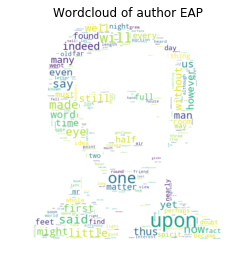

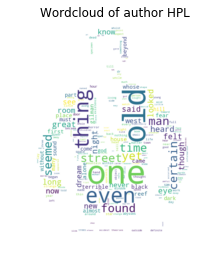

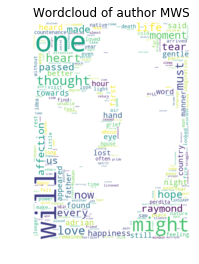

In [9]:
# Read the whole text
list_text = [eap_s_c, hpl_s_c, mws_s_c]

# read the mask image
# taken from http://www.stencilry.org/
eap_mask = np.array(Image.open("eap_mask.jpg"))
hpl_mask = np.array(Image.open("hpl_mask.jpg"))
mws_mask = np.array(Image.open("mws_mask.jpg"))
list_mask = [eap_mask, hpl_mask, mws_mask]

stopwords = set(STOPWORDS)

for i in range(3):
    wc = WordCloud(background_color="white", max_words=2000, mask=list_mask[i],
                   stopwords=stopwords)
    # generate word cloud
    wc.generate(list_text[i])
    # show
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Wordcloud of author ' + author_list[i])
    plt.axis("off")
    plt.figure()
    # store to file
    wc.to_file("{}_wordcloud.png".format(author_list[i]))

plt.show()

<h1>Splitting the training set.</h1>
<br>
Because we have only two datasets, one for training and the other for the Kaggle test. We need to split our 'Kaggle training' set (called t0) into training (called tr1) (in the sense of the training of our predictive model) and testing set (called ts1) (in the sense of testing our models, and not be tested by Kaggle !).<br>
<br>
We shall notice we will choose the best classifier only with the tr1 DataSet. Then, we will test this classifier with ts1 to see if we over-fitted over tr1.<br>
<br>

Once we have chosen the classifier and checked for over-fitting, we will train the chosen classifier over tr1 and ts1. We will use this to predict over the "Kaggle Test Dataset" and create our submission file. 

- Training dataset (19,579 known labels) is split :
 - tr1 (80%)
 - ts1 (20%)
 
- Testing dataset (8,392 un-known labels) is the one we want to predict labels
 

In [10]:
t0 = train.copy()
tr1, ts1 = train_test_split(t0, test_size=20/80)
# 20% to tr1 and 80% to ts1

print('training dataset:', len(t0), 'rows.')
print('tr1:', len(tr1), 'rows.')
print('ts1:', len(ts1), 'rows.')

training dataset: 800 rows.
tr1: 600 rows.
ts1: 200 rows.


In [11]:
tr1.head()

,id,text,author
413,id06151,"I was very sorry for him, for I dislike to see...",HPL
641,id06168,"My preference would be to avoid Paine, since t...",HPL
519,id12355,The apartments of the students were converted ...,EAP
23,id19925,With how deep a spirit of wonder and perplexit...,EAP
755,id06148,After years he began to call the slow sailing ...,HPL


The training dataset is composed of an id, the short text extract and the label(one of the 3 authors). <br> The test doesn't have the label. 

<h1>Feature Engineering (Text Mining)</h1>

The only data we have is the short text extract. So, we will use several text mining technics in order to extract useful features. 

<h2>Meta Features: the form of the text</h2>

These are the features related to the form of the text:
1. Sentence length (characters & words)
2. Word length
3. Punctuation density
4. Percentage of unique words
5. Stopword count
6. Noun/adjective/verb density
7. Adjective to noun ratio
8. Emphases on words or phrases
9. Dialogue density
10. Feminine to masculine words ratio
11. Use of foreign languages

These features don't take into account the substance. It is only about the structure. Text-features are useful because they are related to the way the author is writing (and not the topic). So they are a good way to extract some generalized facts about each one of the authors. 

<h3>Average sentence length (in characters)</h3>

In [12]:
def length_character(var):
    """Takes a string returns an int (average sentence length in characters)."""
    return len(var) / normalization_sentence(var)

<h3>Average sentence length (in words)</h3>

In [13]:
def length_sentence(var):
    """Takes a string and returns an int (average sentence length in words)."""
    return len(var.split()) / normalization_sentence(var)

<h3>Average characters per word</h3>

In [14]:
def length_word(var):
    """Takes a string and returns an int (average characters per word). Excludes punctuations."""
    return len(var.split()) / normalization_word(var)

<h3>Punctuation density</h3>
These features study the use of punctuations by the authors. 

In [15]:
def density_coma(var):
    """Takes a string and returns the ratio of punctuations to characters."""
    cpunc = 0
    for x in var:
        if x == ',':
            cpunc += 1
    return cpunc / normalization_character(var)

In [16]:
def density_point(var):
    """Takes a string and returns the ratio of periods(.) to characters."""
    cpunc = 0
    for x in var:
        if x == '.':
            cpunc += 1
    return cpunc / normalization_character(var)

In [17]:
def density_colon(var):
    """Takes a string and returns the ratio of colons(:) to characters."""
    cpunc = 0
    for x in var:
        if x == ':':
            cpunc += 1
    return cpunc / normalization_character(var)

In [18]:
def density_semicolon(var):
    """Takes a string and returns the ratio of semicolons(;) to characters."""
    cpunc = 0
    for x in var:
        if x == ';':
            cpunc += 1
    return cpunc / normalization_character(var)

In [19]:
def density_interro(var):
    """Takes a string and returns the ratio of question marks(?) to characters."""
    cpunc = 0
    for x in var:
        if x == '?':
            cpunc += 1
    return cpunc / normalization_character(var)

In [20]:
def density_expl(var):
    """Takes a string and returns the ratio of exclamation points(!) to characters."""
    cpunc = 0
    for x in var:
        if x == '!':
            cpunc += 1
    return cpunc / normalization_character(var)

<h3>Percentage of unique words per sentence</h3>
This feature demonstrates the richness of vocabulary. 

In [21]:
def vocabulary_sentence(var):
    """Takes a string and returns the ratio of different words to all words."""
    var = nltk.Text(sent_tokenize(var))
    vocabulary_list = []
    for c in var:
        if normalization_word(c) != 0:
            vacabulary_count_sentence = len({x.lower() for x in word_tokenize(cleaning(c))})
            vocabulary_list.append(vacabulary_count_sentence / normalization_word(c))
    return np.mean(vocabulary_list)

In [22]:
# just a test cell

vocabulary_sentence("Wow, this is a bad one. On Macs running the latest version of High Sierra (10.13.1 (17B48)), it appears that anyone can log in just by putting “root” in the user name field in a certain place. This is a huge, huge problem. Apple will fix it probably within hours but holy moly. Do not leave your Mac unattended")

0.7952797202797204

<h3>Stopword percentage</h3>

Stopwords are common basic english word. It is also a metric of the richness of the vocabulary. 

In [23]:
def density_stopword(var):
    """Takes a string and returns the ratio of stopwords to all words."""
    cs = 0
    for x in nltk.Text(word_tokenize(var)):
        if x in STOPWORDS:
            cs += 1
    return cs/normalization_word(var)

<h3>Noun Density</h3>

In [24]:
def density_noun(var):
    """Takes a string and returns the ratio of nouns to all words."""
    l = []
    for x in nltk.pos_tag(word_tokenize(var)):
        if x[1][0:2] == 'NN': # all noun tags start with NN
            l.append(x)
    return len(l)/normalization_word(var)

<h3>Verb Density</h3>

In [25]:
def density_verb(var):
    """Takes a string and returns the ratio of verbs to all words."""
    l = []
    for x in nltk.pos_tag(word_tokenize(var)):
        if x[1][0:2] == 'VB': # all verb tags start with VB
            l.append(x)
    return len(l)/normalization_word(var)

<h3>Adjective Density</h3>

In [26]:
def density_adjective(var):
    """Takes a string and returns the ratio of adjectives to all words."""
    l = []
    for x in nltk.pos_tag(word_tokenize(var)):
        if x[1][0:2] == 'JJ': # all adjective tags start with JJ
            l.append(x)
    return len(l) / normalization_word(var)

<h3>Adjective to noun ratio</h3>

In [27]:
def adjective_to_noun(var):
    """Takes a string and returns the ratio of adjectives to nouns."""
    return density_adjective(var) / (density_noun(var) + 0.5) # add 0.5 to avoid division by 0 error

<h3>Emphases on Words or Phrases</h3>

In [28]:
def count_emph(var):
    """Takes a string and returns the usage count of emphases using double quotes."""
    emph_trig_words = 'word called the a their my his her for that those like of words'.split() 
    emph_count = 0
    var = var.lower()
    for word in emph_trig_words:
        emph_count += var.count('{} "'.format(word))
    return emph_count

<h3>Dialogues Breaks</h3>

In [29]:
def count_dial_break(var):
    """
    Takes a string and returns the count of dialogue breaks used.
    Example of a dialogue break: ("D ," replied Dupin, "is a desperate man, and a man of nerve.)
    """
    return var.count(", \"")

<h3>Dialogues</h3>

The use of dialogues can also be a particularity of an author. 

In [30]:
def count_dblqt(var):
    """Takes a string and returns the count of sets of double quotes"""
    return ceil(var.count('"')/2) # ceil function rounds up

In [31]:
def count_dial(var):
    """
    Takes a string and returns the count of dialogues used. Assumption is that if in double quotes but not an
    emphasis, then it is a dialogue.
    """
    return count_dblqt(var) - count_emph(var) - count_dial_break(var)

In [32]:
def break_to_dial_ratio(var):
    """Take sa string and returns the ratio of dialogue breaks to dialogues."""
    if not count_dial(var):
        return 0
    return count_dial_break(var) / count_dial(var)

<h3>Feminine and Masculine Words</h3>

In [33]:
def count_fem(var):
    """Takes a string and returns the count of feminine words."""
    fem_words = 'she her woman herself girl women lady queen princess daughter madam madame wife'.split()
    fem_count = 0
    var = cleaning(var)
    for word in var.split():
        if word in fem_words:
            fem_count += 1
    return fem_count

In [34]:
def count_mas(var):
    """Takes a string and returns the count of masculine words."""
    mas_words = 'he his man mr himself boy men gentleman gentlemen king prince son sir husband'.split()
    mas_count = 0
    var = cleaning(var)
    for word in var.split():
        if word in mas_words:
            mas_count += 1
    return mas_count

In [35]:
def fem_to_mas_ratio(var):
    """Takes a string and returns the ratio of feminine words to masculine words."""
    fem_count = count_fem(var)
    mas_count = count_mas(var)
    if fem_count and not mas_count:
        fem_mas_ratio = 1
    elif not fem_count and not mas_count:
        fem_mas_ratio = 0
    else:
        fem_mas_ratio = fem_count / mas_count
    return fem_mas_ratio

In [36]:
df = pd.DataFrame([['EAP', eap_s], ['HPL', hpl_s], ['MWS', mws_s]])
df.columns = ['author', 'text']

for f in [count_emph, count_dial, count_dial_break, break_to_dial_ratio, count_fem, count_mas, fem_to_mas_ratio]:
    df['norm_' + f.__name__] = df.text.apply(f)
    
for f in [count_emph, count_dial, count_dial_break, count_fem, count_mas]: # normalization of count_emph, count_dial, and count_dial_break
    df['norm_' + f.__name__] = df['norm_' + f.__name__] / df.author.apply(lambda x: len(train[train.author == x]))
    
df.head()

,author,text,norm_count_emph,norm_count_dial,norm_count_dial_break,norm_break_to_dial_ratio,norm_count_fem,norm_count_mas,norm_fem_to_mas_ratio
0,EAP,"This process, however, afforded me no means of...",0.012384,0.148607,0.021672,0.145833,0.148607,0.368421,0.403361
1,HPL,It never once occurred to me that the fumbling...,0.008772,0.030702,0.000000,0.000000,0.048246,0.688596,0.070064
2,MWS,How lovely is spring As we looked from Windsor...,0.008032,0.064257,0.052209,0.812500,0.546185,0.614458,0.888889


/Users/Selim/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


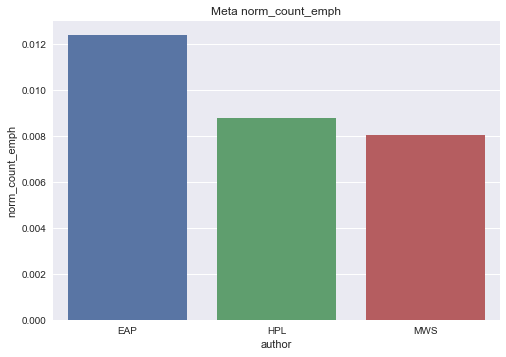

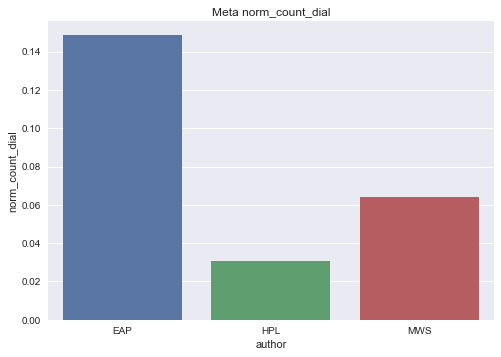

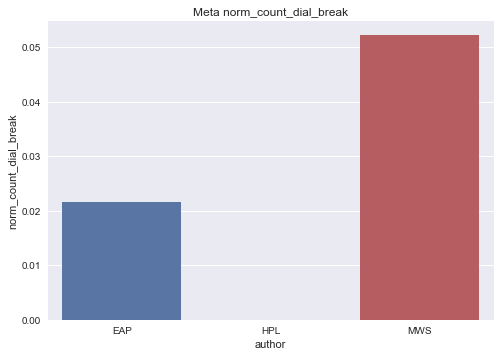

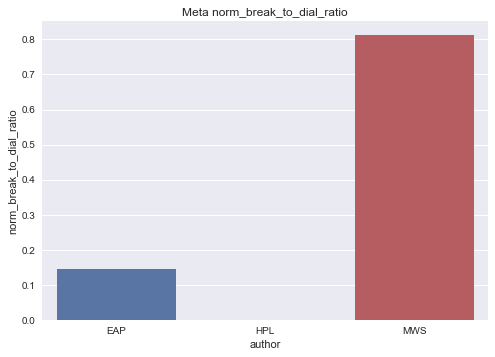

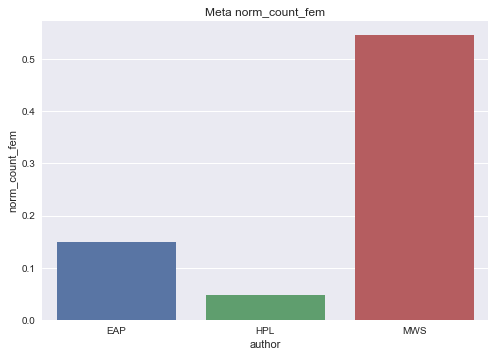

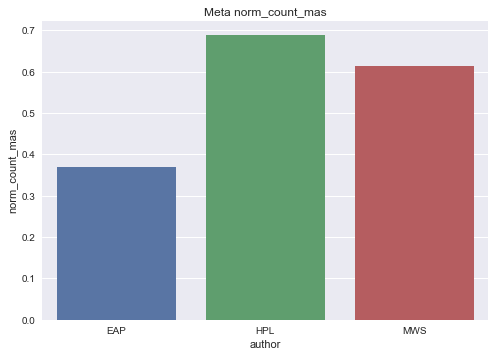

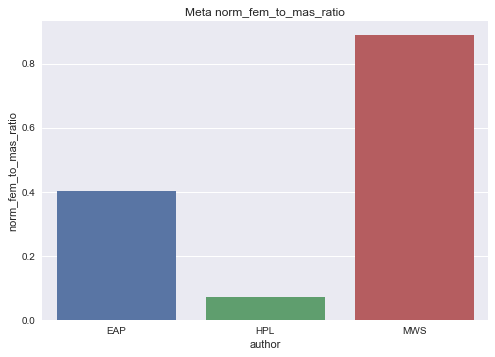

In [37]:

for c in df.columns[2:]:
    plt.style.use('seaborn')
    sns.barplot(x='author', y=c, data=df)
    plt.title('Meta {}'.format(c))
    plt.savefig('Meta {}'.format(c))
    plt.show()


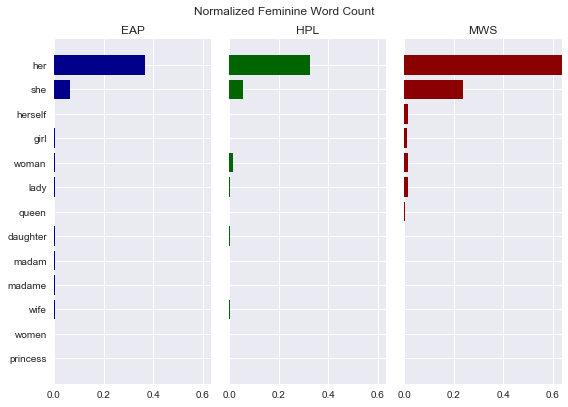

In [38]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fem_words = 'her she herself girl woman lady queen daughter madam madame wife women princess'.split()

plt.suptitle('Normalized Feminine Word Count', y=1.02)

xlmt = 0
for auth in [(eap_s_c, 'EAP'), (hpl_s_c, 'HPL'), (mws_s_c, 'MWS')]:
    for word in fem_words:
        norm_count = auth[0].count(word) / len(train[train.author == auth[1]])
        if norm_count > xlmt:
            xlmt = norm_count

for ax in ((ax1, eap_s_c, 'darkblue', 'EAP'), (ax2, hpl_s_c, 'darkgreen', 'HPL'), (ax3, mws_s_c, 'darkred', 'MWS')):
    y = np.arange(len(fem_words))
    x = [ax[1].count(word) / len(train[train.author == ax[3]]) for word in fem_words]
    ax[0].barh(y, x, align='center',
            color=ax[2], ecolor='black')
    ax[0].set_yticks(y)
    ax[0].set_yticklabels(fem_words)
    ax[0].invert_yaxis()
    ax[0].set_title(ax[3])
    ax[0].set_xlim([0, xlmt])
    
plt.tight_layout()
plt.savefig('Meta feminine word count')
plt.show()


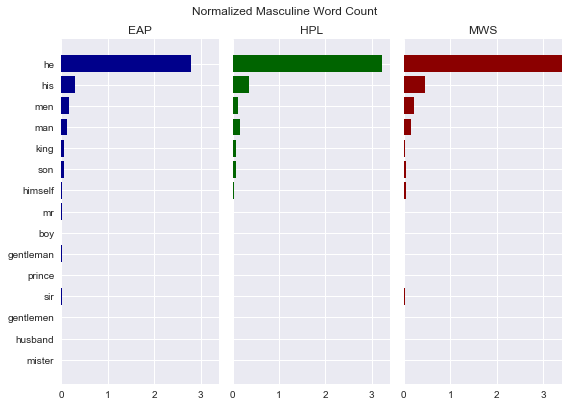

In [39]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
mas_words = 'he his men man king son himself mr boy gentleman prince sir gentlemen husband mister'.split()

plt.suptitle('Normalized Masculine Word Count', y=1.02)

xlmt = 0
for auth in [(eap_s_c, 'EAP'), (hpl_s_c, 'HPL'), (mws_s_c, 'MWS')]:
    for word in mas_words:
        norm_count = auth[0].count(word) / len(train[train.author == auth[1]])
        if norm_count > xlmt:
            xlmt = norm_count
            
for ax in ((ax1, eap_s_c, 'darkblue', 'EAP'), (ax2, hpl_s_c, 'darkgreen', 'HPL'), (ax3, mws_s_c, 'darkred', 'MWS')):
    y = np.arange(len(mas_words))
    x = [ax[1].count(word) / len(train[train.author == ax[3]]) for word in mas_words]
    ax[0].barh(y, x, align='center',
            color=ax[2], ecolor='black')
    ax[0].set_yticks(y)
    ax[0].set_yticklabels(mas_words)
    ax[0].invert_yaxis()
    ax[0].set_title(ax[3])
    ax[0].set_xlim([0, xlmt])
    
plt.tight_layout()
plt.savefig('Meta masculine word count')
plt.show()


The count of masculine/feminine words show some word preferences per author. <br> For example, 'she' is a way lot more used by MWS. 'sir' is used both by EAP and MWS, but not by HPL. 

<h3>Building of the Dataframe of Metadata</h3>

This is the list of all the meta data we are going to use to train our classifiers. We are also going to use bag of words. This could be modified if we add meta data.

In [40]:
def build_meta1(dataframe):
    """Builds a dataframe that shows the author and the first set of meta-data related to the sentence."""
    df_meta = dataframe.copy()
    for f in [count_emph, count_dial, count_dial_break, break_to_dial_ratio, count_fem, count_mas, fem_to_mas_ratio]:
        df_meta[f.__name__] = df_meta.text.apply(f)
    
    del df_meta['text']
    if 'author' in df_meta.columns:
        del df_meta['author']
    
    return df_meta

In [41]:
datameta1 = build_meta1(tr1)
datameta1.head()

,id,count_emph,count_dial,count_dial_break,break_to_dial_ratio,count_fem,count_mas,fem_to_mas_ratio
413,id06151,0,0,0,0.0,0,2,0.0
641,id06168,0,0,0,0.0,0,0,0.0
519,id12355,0,0,0,0.0,0,0,0.0
23,id19925,0,0,0,0.0,0,3,0.0
755,id06148,0,0,0,0.0,0,2,0.0


In [42]:
def build_meta2(dataframe):
    """Builds a dataframe that shows the author and the other meta-data related to the sentence."""
    df_meta = dataframe.copy()
    list_meta = [length_character,
             length_sentence,
             length_word,  
             vocabulary_sentence,
             density_stopword,
             density_noun,
             density_verb,
             density_adjective,
             adjective_to_noun,
             density_coma,
             density_point,
             density_colon,
             density_semicolon,
             density_interro,
             density_expl
            ]
    for f in list_meta:
        df_meta[f.__name__] = df_meta.text.apply(f)
    return df_meta 

In [43]:

datameta2 = build_meta2(tr1)
datameta2.head()


,id,text,author,length_character,length_sentence,length_word,vocabulary_sentence,density_stopword,density_noun,density_verb,density_adjective,adjective_to_noun,density_coma,density_point,density_colon,density_semicolon,density_interro,density_expl
413,id06151,"I was very sorry for him, for I dislike to see...",HPL,102.0,24.0,0.888889,0.703704,0.518519,0.074074,0.185185,0.111111,0.193548,0.009804,0.009804,0.0,0.009804,0.000000,0.0
641,id06168,"My preference would be to avoid Paine, since t...",HPL,92.0,17.0,0.894737,0.842105,0.368421,0.263158,0.157895,0.052632,0.068966,0.010870,0.010870,0.0,0.000000,0.000000,0.0
519,id12355,The apartments of the students were converted ...,EAP,164.0,31.0,0.939394,0.757576,0.575758,0.212121,0.090909,0.090909,0.127660,0.006098,0.006098,0.0,0.000000,0.000000,0.0
23,id19925,With how deep a spirit of wonder and perplexit...,EAP,460.0,82.0,0.845361,0.608247,0.412371,0.206186,0.082474,0.103093,0.145985,0.030435,0.000000,0.0,0.000000,0.002174,0.0
755,id06148,After years he began to call the slow sailing ...,HPL,226.0,41.0,0.931818,0.886364,0.363636,0.250000,0.113636,0.113636,0.151515,0.004425,0.004425,0.0,0.004425,0.000000,0.0


/Users/Selim/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


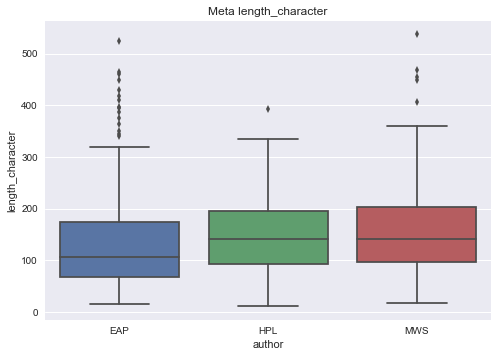

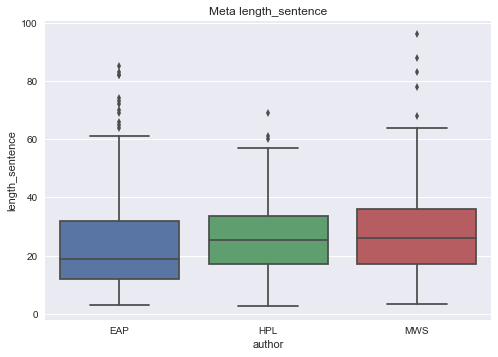

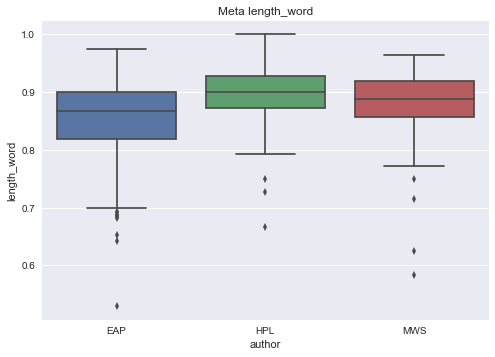

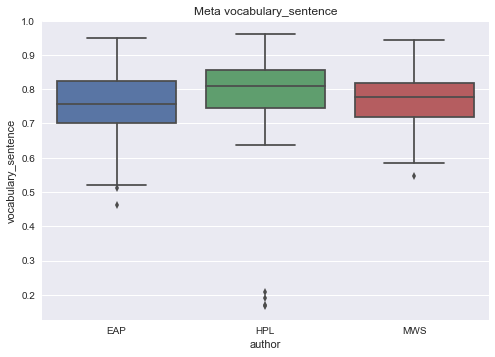

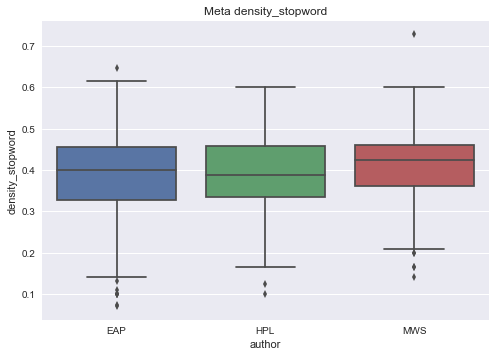

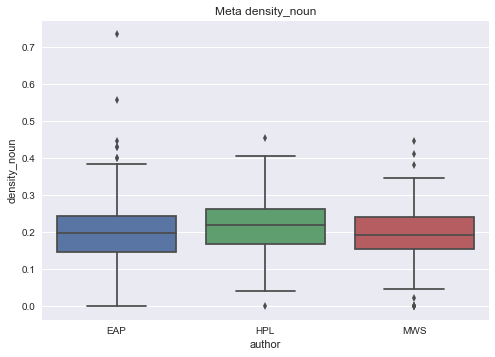

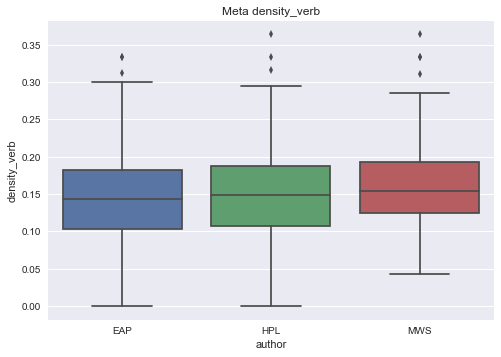

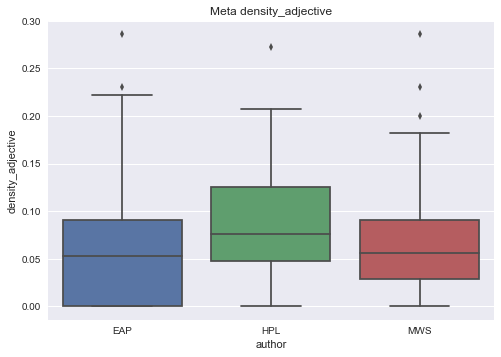

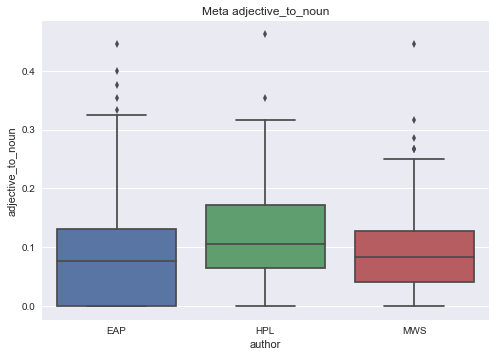

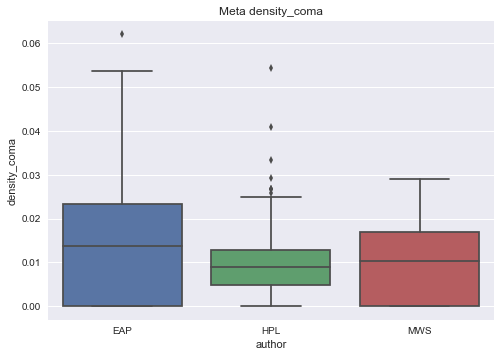

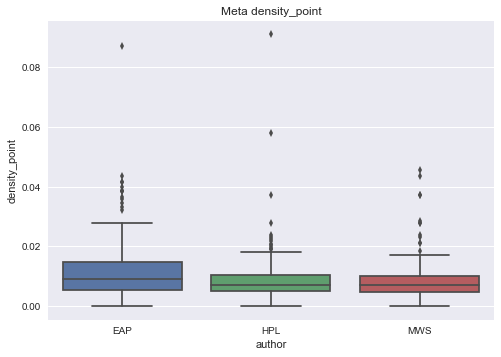

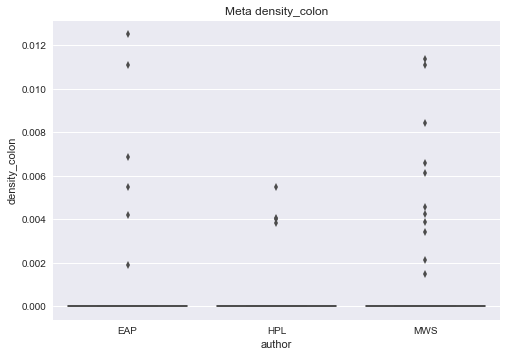

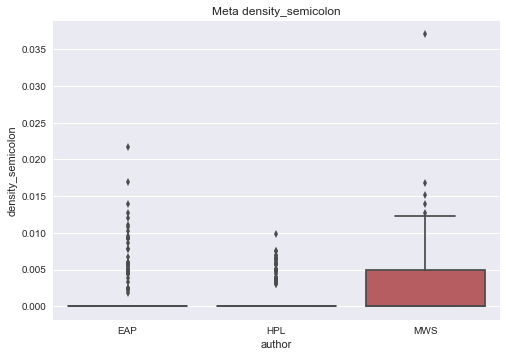

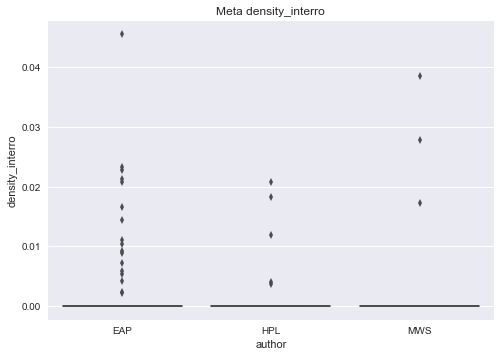

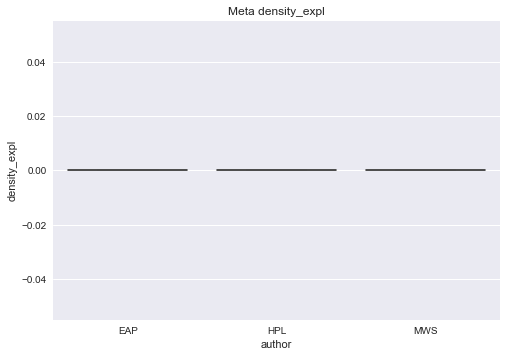

In [44]:
for c in datameta2.columns[3:]:
    plt.style.use('seaborn')
    sns.boxplot(x='author', y=c, data=datameta2)
    plt.title('Meta {}'.format(c))
    plt.savefig('Meta {}'.format(c))
    plt.show()

## Text Features: substance of the text

Now, let's dive into the study of text-features: the study of the substance of the text.

### Foreign Languages 

In this part, we studied the use of foreign (non-english) languages by the authors. Indeed, the use of foreign is important in a sense this can be really specific to the origin of the author for example. 

In [45]:
def language_sent(sents):
    """Takes a list of sentences and returns a list of the languages detected for each sentence."""
    res = list()
    for sent in sents:
        try:
            res.append(detect(sent))
        except:
            pass        
    return res

In [46]:
def language(dataframe):
    """Takes a dataframe and creates a column per language with a value of 1 on the languages used."""
    df = dataframe.copy()
    languages=['af','ca','cy','da','de','es','et','fi','fr','hu','ind','it','nl','no','pl','pt','ro','sk','sl','so','sv','tl','tr','vi']
    for language in languages:
        df[language]=0
        
    for i in range(len(df)):
        sents = nltk.Text(sent_tokenize(df['text'].iloc[i]))
        n = len(sents)
        languages = language_sent(sents)
        for language in languages:
            if language != 'id':
                column = language
                try:
                    df[column].iloc[i] = df[column].iloc[i] + 1 / n
                except:
                    pass
            else:
                column='ind'
                try:
                    df[column].iloc[i] = df[column].iloc[i] + 1 / n
                except:
                    pass
                
    del df['text']
    if 'author' in df.columns:
        del df['author']
        
    return df

In [47]:

datatext5 = language(tr1)
datatext5.head()


/Users/Selim/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,id,af,ca,cy,da,de,es,et,fi,fr,...,pl,pt,ro,sk,sl,so,sv,tl,tr,vi
413,id06151,0.0,0.0,0.0,0,0,0,0,0,0.0,...,0,0.0,0,0,0.0,0.0,0,0,0,0
641,id06168,0.0,0.0,0.0,0,0,0,0,0,0.0,...,0,0.0,0,0,0.0,0.0,0,0,0,0
519,id12355,0.0,0.0,0.0,0,0,0,0,0,0.0,...,0,0.0,0,0,0.0,0.0,0,0,0,0
23,id19925,0.0,0.0,0.0,0,0,0,0,0,0.0,...,0,0.0,0,0,0.0,0.0,0,0,0,0
755,id06148,0.0,0.0,0.0,0,0,0,0,0,0.0,...,0,0.0,0,0,0.0,0.0,0,0,0,0


### POS- Tagging

These are features related to the use of some words at the beginning of sentences. Authors have some preferred types of starting words and so we can use them as features.<br>
Type is noun, adjectives etc... 

#### First Word</h3>

In [48]:
def first_word_type(sents):
    """Takes a list of sentences and returns a list of the word type used to start each element."""
    res = list()
    for sent in sents:
        typ = nltk.pos_tag(sent.split())
        i = 0
        j = 0
        word = typ[i][0].lower()
        while i < len(sent.split()):
            if j < len(word) and word[j] >= 'a' and word[j] <= 'z':
                res.append(typ[i][1])
                break
            i += 1
    return res

In [49]:
def first_word(dataframe):
    """Takes a dataframe and creates a column per word type with a value of 1 on the word type used."""
    df = dataframe.copy()
    elements = ['CC','CD','DT','EX','IN','JJ','JJR','JJS','LS','MD','NN','NNP','NNS','PDT','PRP','PRP$','RB','RBR','TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WRB']
    for element in elements:
        column='first_word_'+element
        df[column]=0
        
    for i in range(len(df)):
        sents = nltk.Text(sent_tokenize(df['text'].iloc[i]))
        first_words = first_word_type(sents)
        for word in first_words:
            column = 'first_word_' + str(word)
            try:
                df[column].iloc[i] += 1
            except:
                pass
            
    del df['text']
    if 'author' in df.columns:
        del df['author']
        
    return df

In [50]:

datatext1 = first_word(tr1)
datatext1.head()


/Users/Selim/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,id,first_word_CC,first_word_CD,first_word_DT,first_word_EX,first_word_IN,first_word_JJ,first_word_JJR,first_word_JJS,first_word_LS,...,first_word_UH,first_word_VB,first_word_VBD,first_word_VBG,first_word_VBN,first_word_VBP,first_word_VBZ,first_word_WDT,first_word_WP,first_word_WRB
413,id06151,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
641,id06168,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
519,id12355,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,id19925,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
755,id06148,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### First Two Words</h3>

In [51]:
def twofirst_words_type(sents):
    """Takes a list of sentences and returns a list of the 2 word types used to start each element."""
    res = list()
    for sent in sents:
        if len(sent.split()) > 1:
            typ = nltk.pos_tag(sent.split())
            res.append([typ[0][1],typ[1][1]])
    return res

In [52]:


def twofirst_word(dataframe):
    """Takes a dataframe and creates a column per word type pair with a value of 1 on the word type pair used."""
    df = dataframe.copy()
    for i in range(len(df)):
        sents = nltk.Text(sent_tokenize(df['text'].iloc[i]))
        twofirst_words = twofirst_words_type(sents)
        for twoword in twofirst_words:
            column = 'first_two_' + str(twoword)
            try:
                df[column].iloc[i] += 1
            except:
                df[column] = 0
                df[column].iloc[i] = 1
                
    del df['text']
    if 'author' in df.columns:
        del df['author']
        
    return df




In [53]:
datatext2 = twofirst_word(tr1)
datatext2.head()

/Users/Selim/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,id,"first_two_['PRP', 'VBD']","first_two_['PRP$', 'NN']","first_two_['DT', 'NNS']","first_two_['IN', 'WRB']","first_two_['IN', 'NNS']","first_two_['PRP', 'VBP']","first_two_['PRP', 'RB']","first_two_['IN', 'DT']","first_two_['WRB', 'RB']",...,"first_two_['RB', 'CD']","first_two_['RB', 'JJ']","first_two_['NNP', 'VBP']","first_two_['VBD', 'NN']","first_two_['RB', 'EX']","first_two_['EX', 'VBP']","first_two_['RB', 'VBD']","first_two_['DT', 'CD']","first_two_['VBG', 'NN']","first_two_['VBD', 'DT']"
413,id06151,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
641,id06168,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
519,id12355,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,id19925,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
755,id06148,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Last Word</h3>

In [54]:
def last_word_type(sents):
    """Takes a list of sentences and returns a list of the word type used to end each element."""
    res= list()
    for sent in sents:
        typ = nltk.pos_tag(sent.split())
        i = 0
        j = 0
        word = typ[-i][0].lower()
        while i < len(sent.split()):
            if j < len(word) and word[j] >= 'a' and word[j] <= 'z':
                res.append(typ[-i][1])
                break
            i += 1
    return res

In [55]:
def last_word(dataframe):
    """Takes a dataframe and creates a column per word type with a value of 1 on the word type used."""
    df = dataframe.copy()
    elements = ['FW','IN','JJ','NN','NNP','NNS','RB','RBS','RP','VB','VBD','VBN','VBP','VBZ']
    for element in elements:
        column='last_word_'+element
        df[column]=0
        
    for i in range(len(df)):
        sents = nltk.Text(sent_tokenize(df['text'].iloc[i]))
        last_words = last_word_type(sents)
        for word in last_words:
            column = 'last_word_' + str(word)
            try:
                df[column].iloc[i] += 1
            except:
                pass
            
    del df['text']
    if 'author' in df.columns:
        del df['author']
        
    return df

In [56]:

datatext3 = last_word(tr1)
datatext3.head()


/Users/Selim/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,id,last_word_FW,last_word_IN,last_word_JJ,last_word_NN,last_word_NNP,last_word_NNS,last_word_RB,last_word_RBS,last_word_RP,last_word_VB,last_word_VBD,last_word_VBN,last_word_VBP,last_word_VBZ
413,id06151,0,0,0,0,0,0,0,0,0,0,0,0,0,0
641,id06168,0,0,0,0,0,0,0,0,0,0,0,0,0,0
519,id12355,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,id19925,0,1,0,0,0,0,0,0,0,0,0,0,0,0
755,id06148,0,1,0,0,0,0,0,0,0,0,0,0,0,0


#### Last Two Words</h3>

In [57]:
def twolast_words_type(sents):
    """Takes a list of sentences and returns a list of the word types used to end each element."""
    res = list()
    for sent in sents:
        if len(sent.split()) > 1:
            typ = nltk.pos_tag(sent.split())
            res.append([typ[-2][1], typ[-1][1]])
    return res

In [58]:

def twolast_word(dataframe):
    """Takes a dataframe and creates a column per word type pair with a value of 1 on the word type pairs used."""
    df=dataframe.copy()
    for i in range(len(df)):
        sents=nltk.Text(sent_tokenize(df['text'].iloc[i]))
        twolast_words = twolast_words_type(sents)
        for twoword in twolast_words:
            column='last_two_' + str(twoword)
            try:
                df[column].iloc[i]=df[column].iloc[i]+1
            except:
                df[column]=0
                df[column].iloc[i]=1
                
    del df['text']
    if 'author' in df.columns:
        del df['author']
        
    return df



In [59]:
datatext4 = twolast_word(tr1)
datatext4.head()

/Users/Selim/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,id,"last_two_['VB', 'NN']","last_two_['DT', 'NN']","last_two_['DT', 'NNP']","last_two_['NN', 'NN']","last_two_['JJ', 'NN']","last_two_['CC', 'NN']","last_two_['CC', 'NNP']","last_two_['TO', 'VB']","last_two_['CC', 'VB']",...,"last_two_['VBG', 'RP']","last_two_['JJR', 'NN']","last_two_['FW', 'NNP']","last_two_['MD', 'VB']","last_two_['VBD', 'NNS']","last_two_['VB', 'VB']","last_two_['RB', 'RB']","last_two_['RB', 'NNP']","last_two_['VBN', 'RB']","last_two_['WP', 'VBP']"
413,id06151,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
641,id06168,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
519,id12355,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,id19925,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
755,id06148,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Emotions </h1>

The following function needs to have the file "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt" in the same folder.
Based on NRC data: 8 emotions

Emotion analysis attributes emotional score for each extract and then build n-features (number of studied emotions).

- 'positive'
- 'anger'
- 'disgust'
- 'fear'
- 'negative'
- 'sadness'
- 'anticipation'
- 'joy'
- 'surprise'
- 'trust'

In [60]:
def get_nrc_data():
    """Builds an emotion dictionary from the NRC emotion lexicon."""
    nrc = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
    count = 0
    emotion_dict = dict()
    with open(nrc,'r') as f:
        all_lines = list()
        for line in f:
            if count < 46:
                count += 1
                continue
            line = line.strip().split('\t')
            if int(line[2]) == 1:
                if emotion_dict.get(line[0]):
                    emotion_dict[line[0]].append(line[1])
                else:
                    emotion_dict[line[0]] = [line[1]]
    return emotion_dict

In [61]:
def emotions(dataframe):
    """Takes a dataframe and creates a column per emotion with a count on the emotions used."""
    df = dataframe.copy()
    emotions=['positive','anger','disgust','fear','negative','sadness','anticipation','joy','surprise','trust']
    for emotion in emotions:
        df[emotion]=0
    
    
    emotion_dic = get_nrc_data()
    for i in range(len(df)):
        words = df['text'].iloc[i].split()
        n = len(words)
        for word in words:
            if word in emotion_dic:
                for emotion in emotion_dic[word]:
                    column = emotion
                    try:
                        df[column].iloc[i] = df[column].iloc[i] + 1 / n
                    except:
                        pass
                    
    del df['text']
    if 'author' in df.columns:
        del df['author']
    
    return df

In [62]:

datatext6 = emotions(tr1)
datatext6.head()


/Users/Selim/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,id,positive,anger,disgust,fear,negative,sadness,anticipation,joy,surprise,trust
413,id06151,0.041667,0.041667,0.041667,0.041667,0.083333,0.041667,0.041667,0.041667,0.041667,0.041667
641,id06168,0.000000,0.000000,0.000000,0.117647,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000
519,id12355,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23,id19925,0.036585,0.000000,0.012195,0.000000,0.036585,0.012195,0.012195,0.012195,0.000000,0.000000
755,id06148,0.073171,0.000000,0.000000,0.000000,0.000000,0.000000,0.048780,0.024390,0.000000,0.024390


<h3>Counting of words (a.k.a Bag of Words)</h3>

Instead of word/ n-grams frequencies, we are going to use tf_idf.

You can find more information about tf_idf on this amazing [git](https://buhrmann.github.io/tfidf-analysis.html).

Basically, the tf_idf is the probability for a n-gram to be present in a given author over present in the 3 authors' corpus. Then, it will extract features(n-grams) which are relevant to identify author. (for example the word 'the' is heavily represented in each corpus so its tf score is low. However the 2-gram: 'immortality man' is heavily represented for EAP and not for the others, it tf score will be high. 



Here, we don't detail for each n-grams. Instead, we'll run the tf_idf for all the n-grams possible and then we'll take the best features. Our aim is to reduce the size/dimensions of our dataset's features.

In [63]:
def transform_tag(var):
    """Transforms a string to a string of pos_tag"""
    inpt = nltk.pos_tag(word_tokenize(var))
    unzipped = zip(*inpt )
    return ' '.join([*list(unzipped)[1]])

<h4>Generation of the tf_idf counting dataFrame</h4>

In [64]:
def counting_a(a, analysis):
    """
    Generates the tf-idf counting dataframe. First argument is the n of n-gram. Analysis type is 'word', 'char',
    token_pos', etc.
    """
    df_train = tr1.copy()
    df_test  = ts1.copy()
    
    #if we are counting words:
    if analysis == "word" or analysis == "char": 
        
        #check the CountVectorizer doc
        #we create a Countvectorizer, called bow_transformer
        bow_transformer = CountVectorizer(analyzer = analysis,
                                      lowercase = True, #we don't care about place in sentence
                                      ngram_range = (a, a),
                                      stop_words='english')

        #we use bow_transformer to fit and transform our training set
        messages_bow = bow_transformer.fit_transform(df_train['text'])
        
        #we use bow_transformer to transform our test set. 
        #We do not need to train if first because the fitting would recompute the idf, we don't want that
        messages_bow_test = bow_transformer.transform(df_test['text'])
    
    #if we are counting POS:    
    elif analysis == "token_pos":
        
        #this is the punctuation we want to keep
        punctuation = r"(?u)\b\w\w+\b|!|\?|\"|\'|\.|\,|\;|\:|\$|\(|\)|\--|\&|\``|\'' + PRP$ + WP$"
        #we create a Countvectorizer, called bow_transformer
        bow_transformer = CountVectorizer(analyzer = 'word',
                                          lowercase = False, #we DO care about place in sentence
                                          ngram_range = (a, a),
                                          token_pattern =  punctuation, #we DO care about punctuation
                                          stop_words='english')
        
        #we use the transform_tag function to transform the sentence in a sentence of pos tag        
        #we use bow_transformer to fit and transform our training set
        messages_bow = bow_transformer.fit_transform(df_train['text'].apply(transform_tag))
        #we use bow_transformer to transform our test set
        #We do not need to train if first because the fitting would recompute the idf, we don't want that
        messages_bow_test = bow_transformer.transform(df_test['text'].apply(transform_tag))

        
    #this is the DataFrame Concerning the regular counting of words
    
    ##from regular counting to tf idf transformation coefficient

    tfidf_transformer = TfidfTransformer().fit(messages_bow)
    messages_tfidf = tfidf_transformer.transform(messages_bow)
    messages_tfidf_test = tfidf_transformer.transform(messages_bow_test)
    
    names = bow_transformer.get_feature_names()
    
    return (messages_tfidf, names, messages_tfidf_test)

In [65]:


#mat_word, name_word, mat_word_test = counting_a(2,'word')
mat_word, name_word, mat_word_test = counting_a(2,'word')

print ('Shape of Sparse Matrix: ', mat_word.shape)
print ('Amount of Non-Zero occurences: ', mat_word.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_word.nnz /
                             (mat_word.shape[0] * mat_word.shape[1])))
       
print(' ')
print ('Shape of Sparse Matrix Test: ', mat_word_test.shape)
print ('Amount of Non-Zero occurences: ', mat_word_test.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_word_test.nnz /
                             (mat_word_test.shape[0] * mat_word_test.shape[1])))
                         

Shape of Sparse Matrix:  (600, 6239)
Amount of Non-Zero occurences:  6261
sparsity: 0.17%
 
Shape of Sparse Matrix Test:  (200, 6239)
Amount of Non-Zero occurences:  19
sparsity: 0.00%


As we can see, we get a matrix with <u>roughly a thousand </u>of  features. It's really heavy and we get a sparse matrix. Our goal is now to reduce the size of this matrix by getting the TOP-N features issued from the tf_idf.<br>
Thanks to the tf score, we'll be able to select the best features in order to create an efficient bag of words.
<br>
And so we can create both the matrix of training set and the matrix of testing. 
Remark, the features columns come from only the training data.<br>
For the testing data, we can use only features previously extracted during the training.

<h4>Reduction of the number of features to N</h4>

The next cell will be called in all the bag of words parts.

In [66]:
def top_tfidf_feats(row, features, top_n=25):
    """Gets top n tf-idf values in row and return them with their corresponding feature names."""
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [67]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    """Returns the top n tf-df features in a specific document (i.e. matrix row)"""
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [68]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    """
    Returns the top n features that on average are most important amongst documents in rows.
    Indentified by indices in grp_ids.
    """
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [69]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    """
    Return a list of dfs, where each df holds top_n features and their mean tfidf value.
    Calculated across documents with the same class label.
    """
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [70]:
def plot_tfidf_classfeats_h(dfs, name = 'default'):
    """Plot the data frames returned by the function plot_tfidf_classfeats()."""
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    #this line is for saving as picture
    plt.savefig(name)
    #this line is for showing
    plt.show()

<h4>Dimensionality reduction for bag of words (example for 2-grams)</h4>
We reduce by taking the TOP-N per author

In [71]:
alpha_word = top_feats_by_class(mat_word, tr1.author, name_word)

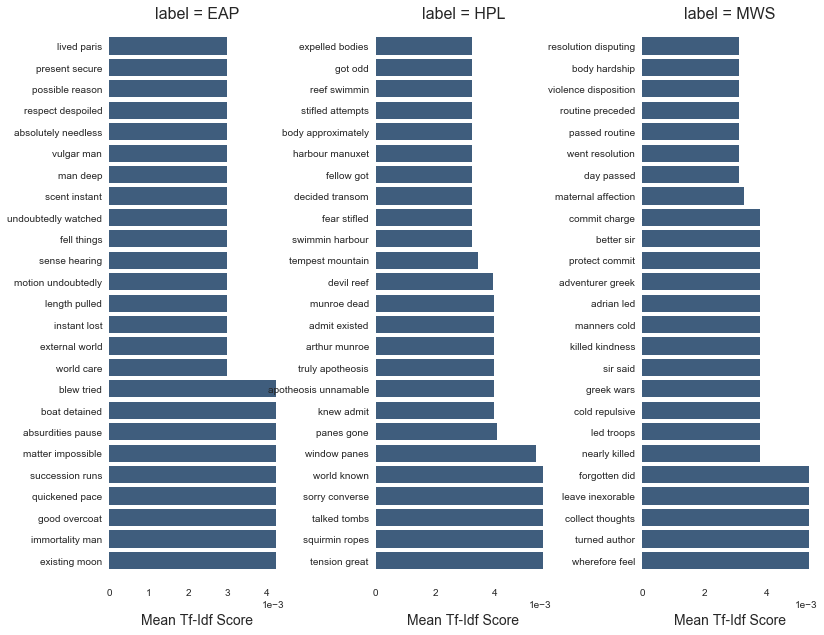

In [72]:
plot_tfidf_classfeats_h(alpha_word, 'bi_gram_word')

#### Building of bag of word and feature vectors</h3>

In [73]:
counting_a(1,'word')

(<600x3994 sparse matrix of type '<class 'numpy.float64'>'
 	with 6741 stored elements in Compressed Sparse Row format>,
 ['abandon',
  'abandoned',
  'abaout',
  'aberrancy',
  'abhorrent',
  'able',
  'abnormal',
  'abode',
  'abodes',
  'abroad',
  'abruptly',
  'absence',
  'absolutely',
  'absurd',
  'absurdities',
  'abundance',
  'abundant',
  'abysms',
  'abysses',
  'academy',
  'acceptance',
  'accession',
  'accident',
  'accompanied',
  'accompany',
  'accomplished',
  'accomplishment',
  'according',
  'accordingly',
  'account',
  'accumulations',
  'accursed',
  'accustomed',
  'achievement',
  'acid',
  'acknowledged',
  'acquainted',
  'acquired',
  'acquirement',
  'acquirements',
  'acquiring',
  'act',
  'acted',
  'acting',
  'action',
  'active',
  'actual',
  'acute',
  'adaptation',
  'added',
  'addition',
  'adequate',
  'adjacent',
  'adjust',
  'adjusted',
  'administered',
  'admiration',
  'admit',
  'admitted',
  'adorned',
  'adrian',
  'adulthood',
  'a

In [74]:
def build_bag_a(a, analysis, top_n = 50):
    df_bag = tr1.copy()
    df_bag_test = ts1.copy()
    
    build = counting_a(a, analysis)
    
    alpha = top_feats_by_class(build[0], df_bag.author, build[1], top_n = top_n)

    a = list(alpha[0].feature.values)
    b = list(alpha[1].feature.values)
    c = list(alpha[2].feature.values)
    bag = set(a + b + c)


    for w in bag:
        vec = build[0][:, build[1].index(w)].toarray()
        df_bag[w] = vec

        vec_test = build[2][:, build[1].index(w)].toarray()
        df_bag_test[w] = vec_test
        
    df_bag = df_bag.drop(labels = ['text','author'], axis = 1)
    df_bag_test = df_bag_test.drop(labels = ['text','author'], axis = 1)

        
    return df_bag, df_bag_test

In [75]:
build_bag_a(4, 'token_pos')[0].shape

(600, 113)

In [76]:
build_bag_a(2, 'word')[0].head()

,id,lived roof,fellow got,immortality man,body hardship,window panes,replied yells,arthur munroe,enchained senses,maternal affection,...,passed routine,absolutely needless,father safie,double hatches,commenced inuring,birch decided,happiness decreased,greek wars,squirmin ropes,violence disposition
413,id06151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
641,id06168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
519,id12355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,id19925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
755,id06148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
build_bag_a(2, 'token_pos')[0].head()

,id,RB VBD,IN JJ,VB PRP,", IN",VBD JJ,PRP $,NNS CC,"PRP ,",", PRP",...,IN NNS,CC IN,RB VBN,"JJ ,",NN CC,NN .,PRP VBZ,NN NN,JJ NNS,NN TO
413,id06151,0.0,0.000000,0.000000,0.148438,0.0,0.000000,0.000000,0.216812,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.186188
641,id06168,0.0,0.000000,0.000000,0.153030,0.0,0.110423,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.108246,0.0,0.169266,0.000000,0.000000
519,id12355,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.130803,0.000000,0.000000
23,id19925,0.0,0.176161,0.138118,0.388608,0.0,0.040059,0.080613,0.000000,0.06161,...,0.146842,0.071137,0.0,0.290979,0.056978,0.039269,0.0,0.061405,0.052703,0.000000
755,id06148,0.0,0.000000,0.121170,0.000000,0.0,0.070286,0.000000,0.000000,0.00000,...,0.128823,0.124815,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.092472,0.000000


So, we get the top N-grams of words. Our problem is the depedency on the topic. We need to produce other features which are less dependant on the topic. There are sereveral possibility. Let's detail: <br>
- Stemming<br>
- Character Counting<br>
- Pos_tagging

### Counting of Character (a.k.a bag of character)</h2>
Here, we count the use of some character, and n-grams of character. Same as previously but with characters.

#### Generation of the tf-idf counting dataFrame</h3>

In [78]:


mat_char, name_char, mat_char_test = counting_a(3, 'char')

print ('Shape of Sparse Matrix: ', mat_char.shape)
print ('Amount of Non-Zero occurences: ', mat_char.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_char.nnz /
                             (mat_char.shape[0] * mat_char.shape[1])))
print(' ')
print ('Shape of Sparse Matrix Test: ', mat_char_test.shape)
print ('Amount of Non-Zero occurences: ', mat_char_test.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_char_test.nnz /
                             (mat_char_test.shape[0] * mat_char_test.shape[1])))

Shape of Sparse Matrix:  (600, 4506)
Amount of Non-Zero occurences:  74809
sparsity: 2.77%
 
Shape of Sparse Matrix Test:  (200, 4506)
Amount of Non-Zero occurences:  23333
sparsity: 2.59%


#### Dimensionnality reduction for bag of characters example for 3 gram</h3>
We reduce by taking the TOP-N per author

In [79]:
alpha_char = top_feats_by_class( mat_char, tr1.author, name_char)

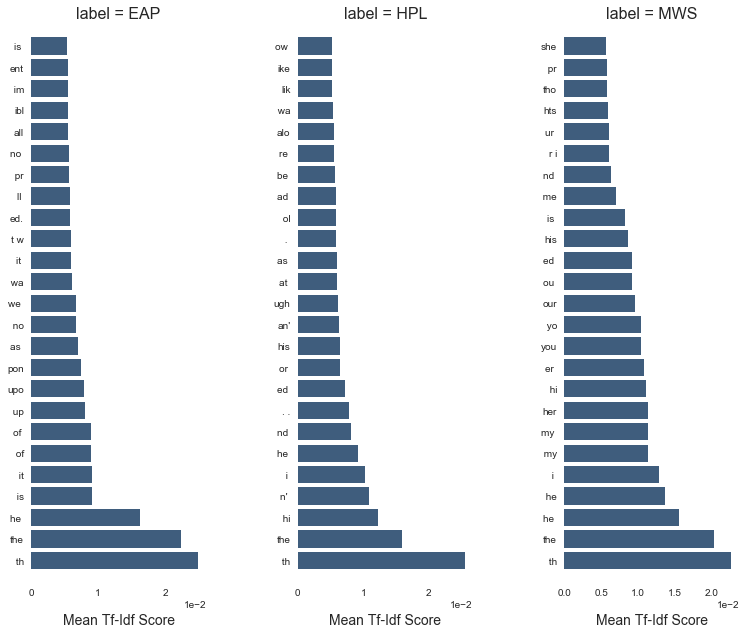

In [80]:
plot_tfidf_classfeats_h(alpha_char, 'tr_gram_char')

#### Building of bag of character and feature vectors</h3>

In [81]:
build_bag_a(3, 'char')[0].shape

(600, 125)

### Counting of POS Tag (a.k.a bag of Tag)</h2>

Here, we count the use of some caracter, and n-grams of caracter.<br>
So we have, some non-topic sensitive features.<br>
But we can produce an other type of feature based on the POS_tagging.

POS tag features. 

We will check the occurence of the elements from the Upenn Tagset. <br>

In [82]:
nltk.download('tagsets')
tagdict = load('help/tagsets/upenn_tagset.pickle')
#list of all the possible tag names
print("|\\".join(list(tagdict)))

#this is the list of the different tokens we will use.
len(tagdict)

[nltk_data] Downloading package tagsets to /Users/Selim/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
LS|\TO|\VBN|\''|\WP|\UH|\VBG|\JJ|\VBZ|\--|\VBP|\NN|\DT|\PRP|\:|\WP$|\NNPS|\PRP$|\WDT|\(|\)|\.|\,|\``|\$|\RB|\RBR|\RBS|\VBD|\IN|\FW|\RP|\JJR|\JJS|\PDT|\MD|\VB|\WRB|\NNP|\EX|\NNS|\SYM|\CC|\CD|\POS


45

<h3>Generation of the tf-idf counting dataFrame</h3>
We had to adapt the arguments passed in the CountVectorizer.

In [83]:


mat_pos, name_pos, mat_pos_test = counting_a(4, 'token_pos')

print ('Shape of Sparse Matrix: ', mat_pos.shape)
print ('Amount of Non-Zero occurences: ', mat_pos.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_pos.nnz /
                             (mat_pos.shape[0] * mat_pos.shape[1])))

print ('Shape of Sparse Test Matrix: ', mat_pos_test.shape)
print ('Amount of Non-Zero occurences: ', mat_pos_test.nnz)
print ('sparsity: %.2f%%' % (100.0 * mat_pos_test.nnz /
                             (mat_pos_test.shape[0] * mat_pos_test.shape[1])))
                             


Shape of Sparse Matrix:  (600, 7884)
Amount of Non-Zero occurences:  16702
sparsity: 0.35%
Shape of Sparse Test Matrix:  (200, 7884)
Amount of Non-Zero occurences:  3572
sparsity: 0.23%


<h3>Dimensionnality reduction for bag of tags Example for 2 grams</h3>
We reduce by taking the TOP-N per author

In [84]:
alpha_pos = top_feats_by_class(mat_pos, tr1.author, name_pos, top_n = 10)

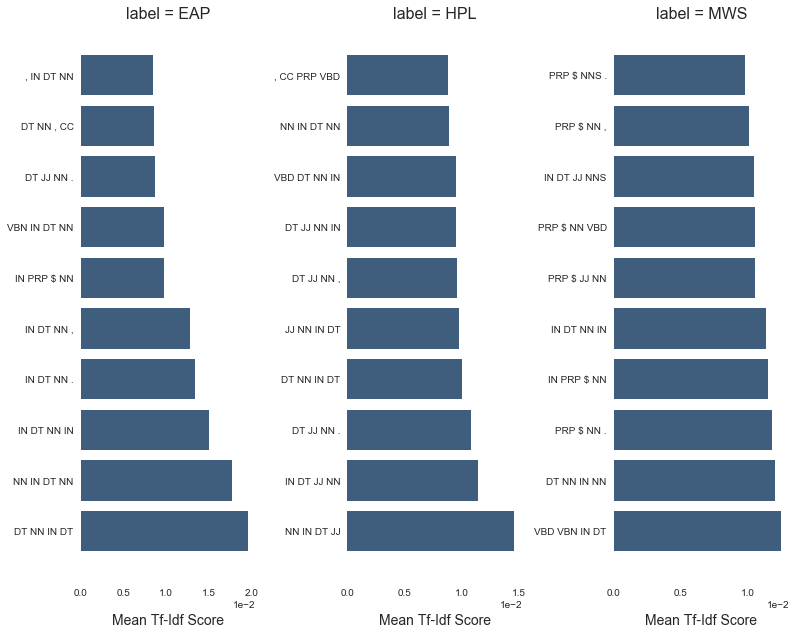

In [85]:
plot_tfidf_classfeats_h(alpha_pos, "four_gram_tag_pos")

<h3>Building of bag of tag and feature vectors</h3>

In [86]:
build_bag_a(2,'token_pos')[0].head()

,id,RB VBD,IN JJ,VB PRP,", IN",VBD JJ,PRP $,NNS CC,"PRP ,",", PRP",...,IN NNS,CC IN,RB VBN,"JJ ,",NN CC,NN .,PRP VBZ,NN NN,JJ NNS,NN TO
413,id06151,0.0,0.000000,0.000000,0.148438,0.0,0.000000,0.000000,0.216812,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.186188
641,id06168,0.0,0.000000,0.000000,0.153030,0.0,0.110423,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.108246,0.0,0.169266,0.000000,0.000000
519,id12355,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.130803,0.000000,0.000000
23,id19925,0.0,0.176161,0.138118,0.388608,0.0,0.040059,0.080613,0.000000,0.06161,...,0.146842,0.071137,0.0,0.290979,0.056978,0.039269,0.0,0.061405,0.052703,0.000000
755,id06148,0.0,0.000000,0.121170,0.000000,0.0,0.070286,0.000000,0.000000,0.00000,...,0.128823,0.124815,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.092472,0.000000


### Positivity/Negativity</h2>


Vader contains a list of 7500 features weighted by how positive or negative they are</h4>
<br>It uses these features to calculate stats on how positive, negative and neutral a passage is and combines these results to give a compound sentiment (higher = more positive) for the passage.<br>
<br>Human trained on twitter data and generally considered good for informal communication<br>
<br>10 humans rated each feature in each tweet in context from -4 to +4</h4>
<br>Calculates the sentiment in a sentence using word order analysis</h4>
<br>"marginally good" will get a lower positive score than "extremely good"
<br>Computes a "compound" score based on heuristics (between -1 and +1)</h4>
<br>Includes sentiment of emoticons, punctuation, and other 'social media' lexicon elements<br>

In [87]:
def vader_comparison(texts):
    headers = ['pos','neg','neu','compound']
    analyzer = SentimentIntensityAnalyzer()
    sentences = sent_tokenize(texts)
    pos = compound = neu = neg = 0
    num_sentences = len(sentences)
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        pos += vs['pos'] / num_sentences
        compound += vs['compound'] / num_sentences
        neu += vs['neu'] / num_sentences
        neg += vs['neg'] / num_sentences
    return pos, neg, neu, compound

def density_positive(var):
    return vader_comparison(var)[0]

def density_negative(var):
    return vader_comparison(var)[1]

def density_neutral(var):
    return vader_comparison(var)[2]

def density_compound(var):
    return vader_comparison(var)[3]

In [88]:
def build_sensi(dataframe):
    df_sen = dataframe.copy() #change here to make sense
    
    df_sen[density_positive.__name__] = df_sen.text.apply(density_positive)
    df_sen[density_negative.__name__] = df_sen.text.apply(density_negative)
    df_sen[density_neutral.__name__] = df_sen.text.apply(density_neutral)
    df_sen[density_compound.__name__] = df_sen.text.apply(density_compound)
    
    del df_sen['text']
    if 'author' in df_sen.columns:
        del df_sen['author']
    return df_sen

build_sensi(ts1).shape

(200, 5)

In [89]:

datatext7 = build_sensi(tr1)
datatext7.head()


,id,density_positive,density_negative,density_neutral,density_compound
413,id06151,0.000,0.479,0.521,-0.9154
641,id06168,0.000,0.235,0.765,-0.5574
519,id12355,0.000,0.068,0.932,-0.2960
23,id19925,0.087,0.038,0.874,0.6354
755,id06148,0.043,0.161,0.796,-0.6705


# Construction of the X_train and X_test with all the features

In [90]:
#we build here the 2 feature datasets (one for TR1, one for TS1)
#should be adapted when we'll add features

def build_bunch_tr1(dataframe):
    list_df_tr = [build_meta2(dataframe),
                  build_meta1(dataframe),
                  build_sensi(dataframe),
                  build_bag_a(1, 'word')[0],
                  build_bag_a(2, 'word')[0],
                  build_bag_a(3, 'word')[0],
                  build_bag_a(1, 'char')[0],
                  build_bag_a(2, 'char')[0],
                  build_bag_a(3, 'char')[0],
                  build_bag_a(4, 'char')[0],
                  build_bag_a(5, 'char')[0],
                  build_bag_a(6, 'char')[0],
                  build_bag_a(7, 'char')[0],
                  build_bag_a(1, 'token_pos')[0],
                  build_bag_a(2, 'token_pos')[0],
                  build_bag_a(3, 'token_pos')[0],
                  build_bag_a(4, 'token_pos')[0],
                  build_bag_a(5, 'token_pos')[0],
                  build_bag_a(6, 'token_pos')[0],
                  first_word(dataframe),
#                   twofirst_word(dataframe),
                  last_word(dataframe),
#                   twolast_word(dataframe),
                  language(dataframe),
                  emotions(dataframe)
              ]
    bunch = pd.merge(list_df_tr[0], list_df_tr[1])
    
    for i in range(2, len(list_df_tr)):
        alpha = bunch
        bunch = pd.merge(alpha, list_df_tr[i], on = 'id')
    
    return bunch

df_feat_tr1 = build_bunch_tr1(tr1)

/Users/Selim/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [91]:
def build_bunch_ts1(dataframe):
    list_df_ts = [build_meta2(dataframe),
                  build_meta1(dataframe),
                  build_sensi(dataframe),
                  build_bag_a(1,'word')[1],
                  build_bag_a(2,'word')[1],
                  build_bag_a(3,'word')[1],
               
                  build_bag_a(1,'char')[1],
                  build_bag_a(2,'char')[1],
                  build_bag_a(3,'char')[1],
                  build_bag_a(4,'char')[1],
                  build_bag_a(5,'char')[1],
                  build_bag_a(6,'char')[1],
                  build_bag_a(7,'char')[1],
               
                  build_bag_a(1, 'token_pos')[1],
                  build_bag_a(2, 'token_pos')[1],
                  build_bag_a(3, 'token_pos')[1],
                  build_bag_a(4, 'token_pos')[1],
                  build_bag_a(5, 'token_pos')[1],
                  build_bag_a(6, 'token_pos')[1],
                  first_word(dataframe),
#                   twofirst_word(dataframe),
                  last_word(dataframe),
#                   twolast_word(dataframe),
                  language(dataframe),
                  emotions(dataframe)
                 ]

    bunch = pd.merge(list_df_ts[0], list_df_ts[1])
    
    for i in range(2, len(list_df_ts)):
        print(bunch.shape)
        bunch = pd.merge(bunch, list_df_ts[i], on = 'id')
    
    return bunch
df_feat_ts1 = build_bunch_ts1(ts1)

/Users/Selim/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(200, 25)
(200, 29)
(200, 165)
(200, 315)
(200, 465)
(200, 502)
(200, 571)
(200, 695)
(200, 838)
(200, 987)
(200, 1137)
(200, 1287)
(200, 1325)
(200, 1402)
(200, 1503)
(200, 1615)
(200, 1740)
(200, 1880)
(200, 1909)
(200, 1923)
(200, 1947)


In [92]:
print ('Shape of df_feat_tr1 Matrix: ', df_feat_tr1.shape)
print ('Amount of Non-Zero occurences: ', np.count_nonzero(df_feat_tr1.values))
print ('sparsity: %.2f%%' % (100.0 * np.count_nonzero(df_feat_tr1.values) /
                                 (df_feat_tr1.shape[0] * df_feat_tr1.shape[1])))
print('')

print ('Shape of df_feat_ts1 Matrix: ', df_feat_ts1.shape)
print ('Amount of Non-Zero occurences: ', np.count_nonzero(df_feat_ts1.values))
print ('sparsity: %.2f%%' % (100.0 * np.count_nonzero(df_feat_ts1.values) /
                                 (df_feat_ts1.shape[0] * df_feat_ts1.shape[1])))

Shape of df_feat_tr1 Matrix:  (600, 1957)
Amount of Non-Zero occurences:  103599
sparsity: 8.82%

Shape of df_feat_ts1 Matrix:  (200, 1957)
Amount of Non-Zero occurences:  32917
sparsity: 8.41%


<h1>Prediction: Selection of best set of feature selection technique and prediction model </h1>

<h2>Quantitative parameters transformation</h2>
Quantitative parameters were transferred into a numerical vector with min-max normalization
from 0 to 1. <br>
<br>
It is necessary to have normalized vectors before training our dataset to avoid a disequilibrium among the coefficients.<br>
This is particularly true because we will use technics such as PCA which requires the use of normalization because it needs the same range of variation in order to compare variances of the features.  

http://blog.josephmisiti.com/help-commands-for-doing-machine-learning-in-python

In [93]:
def build_normalization(df):
    result = df.copy()
    for feature_name in list(df)[3:]:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value != min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result
build_normalization(df_feat_ts1).head()



,id,text,author,length_character,length_sentence,length_word,vocabulary_sentence,density_stopword,density_noun,density_verb,...,positive,anger,disgust,fear,negative,sadness,anticipation,joy,surprise,trust
0,id19227,And when did the radiant Una ask anything of h...,EAP,0.080153,0.101124,0.881148,0.976701,0.607143,0.685714,0.202381,...,0.384615,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.384615,0.0,0.000000
1,id01837,"In the present instance, had the gold been gon...",EAP,0.234733,0.235955,0.793033,0.819436,0.678571,0.400000,0.505952,...,0.600000,0.000000,0.0,0.0,0.000000,0.0,0.40000,0.200000,0.3,0.600000
2,id14749,"The state rooms were sufficiently roomy, and e...",EAP,0.124046,0.123596,0.646175,0.755365,0.527778,0.266667,0.472222,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000
3,id14118,"""Vase am I,"" she thought, ""vase brimful of des...",MWS,0.089695,0.078652,0.097905,0.510730,0.083333,0.444444,0.314815,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000
4,id12020,"Scarcely had we recovered our senses, before t...",EAP,0.368321,0.393258,0.827869,0.808464,0.726744,0.334884,0.395349,...,0.256410,0.102564,0.0,0.0,0.102564,0.0,0.25641,0.128205,0.0,0.192308


So now, we have the normalized features matrix. 

<h2>Load and prepare data</h2>

This below loads the data and put the matrices in shape for the predictive part.

In [94]:
# load dataset

names = author_list
dataframe_train = build_normalization(build_bunch_tr1(tr1))
dataframe_train.to_csv('dataframe_train')
array = dataframe_train.values
X_train = array[:,3:]
Y_train = array[:,2]

names = author_list
dataframe_test = build_normalization(build_bunch_ts1(ts1))
dataframe_test.to_csv('dataframe_test')
array = dataframe_test.values
X_test = array[:,3:]
Y_test = array[:,2]

/Users/Selim/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(200, 25)
(200, 29)
(200, 165)
(200, 315)
(200, 465)
(200, 502)
(200, 571)
(200, 695)
(200, 838)
(200, 987)
(200, 1137)
(200, 1287)
(200, 1325)
(200, 1402)
(200, 1503)
(200, 1615)
(200, 1740)
(200, 1880)
(200, 1909)
(200, 1923)
(200, 1947)


In [95]:

print(np.shape(X_train))
print(np.shape(X_test))


(600, 1954)
(200, 1954)


<h2>Feature Selection</h2><br>
See:http://scikit-learn.org/stable/modules/feature_selection.html <br><br>
Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested.<br>
<br>
Having irrelevant features in your data can decrease the accuracy of many models, especially linear algorithms like linear and logistic regression.<br>
<br>
Three benefits of performing feature selection before modeling your data are:<br>
<br>
- <b>Reduces Overfitting:</b> Less redundant data means less opportunity to make decisions based on noise.<br>
    <br>
- <b>Improves Accuracy:</b> Less misleading data means modeling accuracy improves.<br>
    <br>
- <b>Reduces Training Time:</b> Less data means that algorithms train faster.
<br><br>I will not follow the paper here but rather I'll follow the following website: <br>

https://machinelearningmastery.com/feature-selection-machine-learning-python/ <br>
see also: https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/

So, here we will try a bunch of different methods:<br>
- Univariate feature selection
- Recursive feature elimination
- PCA


<h3>Number of selected features</h3>

<h4>Current number of features</h4>

In [96]:
print('We have ' + str(np.shape(X_train)[1]) + ' features in total.')

We have 1954 features in total.


<h4>Reduction of  number of feaures</h4>
The common possibilities are 10,20, quarter and half of total number of samples. <br>
<br>
For now, we only explore with quarter, tbd for the others.

In [97]:
list_N = [10, 20, int(np.shape(X_train)[1]/4), int(np.shape(X_train)[1]/2)]

print('We want to test our models with ' + str(list_N) + ' features extracted from the ' + str(np.shape(X_train)[1]) + ' previous features')

We want to test our models with [10, 20, 488, 977] features extracted from the 1954 previous features


<h3>Univariate feature selection</h3>

In [98]:
def sel_univ(N):
    return SelectKBest(chi2, k=N)

<h3>Recursive feature elimination</h3>

In [99]:
def sel_rec(N):
    model_rec = LogisticRegression()
    return RFE(model_rec, N)

<h3>Principal Component Analysis</h3>


In [100]:
def sel_pca(N):
    return PCA(n_components=N)

<h3>Summary</h3>

In [101]:
def build_selec(N):
    selectioners = []  
    selectioners.append(('S_UNIV_{}'.format(N), sel_univ(N)))
    selectioners.append(('S_REC_{}'.format(N), sel_rec(N)))
    selectioners.append(('S_PCA_{}'.format(N), sel_pca(N)))
    return selectioners

<h2>Predictive Models</h2><br>
So here we will try this bunch of feature models:

In [122]:
def build_models(N):
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('RFC', RandomForestClassifier()))
    return models

<h2>Pipeline</h2><br>

Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. 

In [123]:
def build_pipes(N):
    pipes = []
    for sel in build_selec(N):
        for mod in build_models(N):
            pipes.append([sel, mod])
    return pipes

<h2>Compare set of selection and predictive models</h2>
<br>


In order to reduce over-fitting, we will try all the pipelines using k-fold cross validation with k=10.

<b>First</b>, we do ten times :<br>
- First we train over 9/10 of the training set (TR1)
- We test over the 1/10 remaining of the training set (TR1)<br>
<br>
But here we have a problem. Actually, the metric we need to measure the models is 'neg_log_loss', because it is the one used by Kaggle. But it doesn't work and we don't know why. So, the metric used is accuracy. <br>
<br>

<b>Then</b>, we will take the 10 best models using a hand-crafted criterion (see above):<br>
- We train over the whole train set(TR1)
- We test over the whole test set (TS1)
- We measure the best with the neg_log_loss metric (here it's working)<br>

<b>Finally</b>, the selected one will be used for the final submission. 

In [124]:
def build_list_models():
    list_all = []
    for n in list_N:
        list_all.extend(build_pipes(n))
    return list_all
        
all_pipes = build_list_models()

all_pipes[0]

[('S_UNIV_10', SelectKBest(k=10, score_func=<function chi2 at 0x111b9d400>)),
 ('LR',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))]

We use a monitoring dataframe in order to help us retrieve the best models.

In [125]:
list_name_pipe = []

for pipe in all_pipes:
    feat = pipe[0]
    model = pipe[1]    
    list_name_pipe.append(feat[0] + ' ' + model[0])


monitoring = pd.DataFrame( index = list_name_pipe, columns = ['started', 'start_time', 'ended', 'end_time', 'delta', 'mean', 'std', 'criterion'] )
monitoring.head()

,started,start_time,ended,end_time,delta,mean,std,criterion
S_UNIV_10 LR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S_UNIV_10 KNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S_UNIV_10 CART,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S_UNIV_10 NB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S_UNIV_10 GBC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Above, the monitoring dataframe. Mean is the mean of the log_loss along the 10 cross validations per model. std the standard deviation and <b>criterion</b> is a home hand-crated such as it equals the mean minus the half of the std. The idea here is to base our selection both on mean and variance of the pipeline. 

In [126]:
def eval_N(pipe):
    """
    This function takes a pipeline as input and it return the mean, variance, criterion score of this pipeline.
    This values are computed according to the results of the k-fold cross validation made with the tr1 dataset.
    """

    intermediate_time = datetime.now()
    seed = 7    
    feat = pipe[0]
    model = pipe[1]
    
    name = feat[0] + ' ' + model[0]
    
    monitoring['started'][name] = True
    monitoring['start_time'][name] = intermediate_time
    
    
    print('Go: ' + name + '\n')
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    pipeline = Pipeline([feat, model])
    scorer = 'neg_log_loss'
    cv_results = model_selection.cross_val_score(pipeline,
                                                 X_train,
                                                 Y_train,
                                                 cv=kfold,
                                                 scoring = scorer)
    results = cv_results
    results_mean_var = (feat[0] + ' ' + model[0], cv_results.mean(), cv_results.var(), cv_results.mean()-0.5*cv_results.std())
    #names_model.append(feat[0] + ' ' + model[0])
    msg = "%s: Mean=%f Stand Dev=(%f)" % ('Selector: ' + feat[0] + ' Predictive model: ' + model[0], cv_results.mean(), cv_results.std())
    print(msg)
    end_time = datetime.now()
    print('Running time: {}'.format(end_time - start_time))
    print('Intermediate time: {}'.format(end_time - intermediate_time))
    
    monitoring['ended'][name] = True
    monitoring['end_time'][name] = end_time
    monitoring['delta'][name] = end_time-intermediate_time
    monitoring['mean'][name] = cv_results.mean()
    monitoring['std'][name] = cv_results.var()
    monitoring['criterion'][name] = cv_results.mean()-0.5*cv_results.std()
    
    return (results, results_mean_var)




We use here multiprocessing to share the computation between several processors (4 on the laptop but up to 64 on Google Cloud ! ) in order to speed-up the computation.

For computation time, we execute here only 20 pipelines.

In [129]:
%%time

debut = datetime.now()

#the multiprocessing libray is used here to speed-up th execution of the code. 
pool = Pool(1) 
training_results = pool.map(eval_N, all_pipes[:20])

pool.close()
pool.join()

fin = datetime.now()
print('c fini:' + str(fin - debut))

Go: S_UNIV_10 LR



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_UNIV_10 Predictive model: LR: Mean=-1.017230 Stand Dev=(0.063939)
Running time: 15:20:45.312629
Intermediate time: 0:00:03.620811
Go: S_UNIV_10 KNN



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_UNIV_10 Predictive model: KNN: Mean=-4.459187 Stand Dev=(1.930454)
Running time: 15:20:48.964080
Intermediate time: 0:00:03.650415
Go: S_UNIV_10 CART



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_UNIV_10 Predictive model: CART: Mean=-10.088177 Stand Dev=(2.453279)
Running time: 15:20:52.704301
Intermediate time: 0:00:03.738275
Go: S_UNIV_10 NB



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_UNIV_10 Predictive model: NB: Mean=-10.573668 Stand Dev=(4.378102)
Running time: 15:20:56.265196
Intermediate time: 0:00:03.559844
Go: S_UNIV_10 GBC



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_UNIV_10 Predictive model: GBC: Mean=-1.117460 Stand Dev=(0.140644)
Running time: 15:21:01.856776
Intermediate time: 0:00:05.590273
Go: S_UNIV_10 ABC



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_UNIV_10 Predictive model: ABC: Mean=-1.070765 Stand Dev=(0.015282)
Running time: 15:21:06.071305
Intermediate time: 0:00:04.213660
Go: S_UNIV_10 ETC



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_UNIV_10 Predictive model: ETC: Mean=-5.118066 Stand Dev=(2.696482)
Running time: 15:21:09.564835
Intermediate time: 0:00:03.492621
Go: S_UNIV_10 RFC



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_UNIV_10 Predictive model: RFC: Mean=-4.180450 Stand Dev=(2.021261)
Running time: 15:21:13.080090
Intermediate time: 0:00:03.513788
Go: S_REC_10 LR



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_REC_10 Predictive model: LR: Mean=-0.949857 Stand Dev=(0.043805)
Running time: 15:31:30.980256
Intermediate time: 0:10:17.899350
Go: S_REC_10 KNN



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_REC_10 Predictive model: KNN: Mean=-5.291391 Stand Dev=(1.181165)
Running time: 15:41:29.457516
Intermediate time: 0:09:58.475605
Go: S_REC_10 CART



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_REC_10 Predictive model: CART: Mean=-18.204239 Stand Dev=(2.109139)
Running time: 15:51:32.148111
Intermediate time: 0:10:02.689397
Go: S_REC_10 NB



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_REC_10 Predictive model: NB: Mean=-6.402125 Stand Dev=(1.583568)
Running time: 16:01:33.796803
Intermediate time: 0:10:01.647913
Go: S_REC_10 GBC



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_REC_10 Predictive model: GBC: Mean=-0.993420 Stand Dev=(0.096868)
Running time: 16:12:41.956894
Intermediate time: 0:11:08.159180
Go: S_REC_10 ABC



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_REC_10 Predictive model: ABC: Mean=-1.064194 Stand Dev=(0.014959)
Running time: 16:30:08.810261
Intermediate time: 0:17:26.849076
Go: S_REC_10 ETC



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_REC_10 Predictive model: ETC: Mean=-4.709732 Stand Dev=(1.581231)
Running time: 16:40:25.241960
Intermediate time: 0:10:16.422772
Go: S_REC_10 RFC



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_REC_10 Predictive model: RFC: Mean=-3.646647 Stand Dev=(1.453482)
Running time: 16:50:41.545944
Intermediate time: 0:10:16.302624
Go: S_PCA_10 LR



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_PCA_10 Predictive model: LR: Mean=-0.915242 Stand Dev=(0.074783)
Running time: 16:50:45.303248
Intermediate time: 0:00:03.756545
Go: S_PCA_10 KNN



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_PCA_10 Predictive model: KNN: Mean=-3.927485 Stand Dev=(1.327155)
Running time: 16:50:48.874955
Intermediate time: 0:00:03.570911
Go: S_PCA_10 CART



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_PCA_10 Predictive model: CART: Mean=-18.420681 Stand Dev=(2.273621)
Running time: 16:50:52.435988
Intermediate time: 0:00:03.560198
Go: S_PCA_10 NB



/Users/Selim/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


Selector: S_PCA_10 Predictive model: NB: Mean=-0.932067 Stand Dev=(0.080523)
Running time: 16:50:56.071593
Intermediate time: 0:00:03.634745
c fini:1:30:14.470149
CPU times: user 1h 17min 12s, sys: 4min 35s, total: 1h 21min 47s
Wall time: 1h 30min 14s


<h2>Selection of selection and predictive models</h2>
<br> We take the ten best estimators according to the criterion.

These will be tested other the 'TS1' test dataset and trained with the whole 'TS1'. <br>


In [130]:
def get_and_select_results_mean_var():
    list_res = [] #total list of results
    selection = [] #top ten in term of average 
                   #subject to be in the criterion in term of mean
    
    
    for i in range(len(training_results)):
        list_res.append((training_results[i][1]))
        
    list_res.sort(key=lambda tup: tup[3], reverse = True)
    
    selection = list_res[:10]

    return selection

selected_feat_model = get_and_select_results_mean_var()


<h1>Testing over the Testing dataset</h1> <br>
Now, we have to test the top-10 models over the remaining training set. Our aim is to see how are they are behaviouring over an un-known dataset and select the best. We will also, and it's the most import ensure there is no over-fitting. 

<h2>List of selected</h2>

In [131]:
best_pipes = []

for j in range(len(selected_feat_model)):
    for n in list_N[:2]:    
        for i in range(len(build_pipes(n))):
            f = build_pipes(n)[i][0][0] + ' ' + build_pipes(n)[i][1][0]
            if f == selected_feat_model[j][0]:
                best_pipes.append((f, build_pipes(n)[i]))
print('These are the',len(best_pipes),'best selected pieplines.')         

These are the 10 best selected pieplines.


<h2>Confusion Matrix</h2>

Above, the functions to draw the confusion matrices. Confusion matrices are useful for the interpretation of the results. It enables to visualize and compute metrics (precision, recall, F1-score) more precise than the accuracy.

In [132]:
# import some data to play with

class_names = author_list




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [133]:
def final_plot_confusion(Y_test, Y_pred):

    cm = confusion_matrix(Y_test, Y_pred)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()


<h2>Test over Top Pipeline</h2>

In [134]:
log_loss_list = []
for i in range(len(best_pipes)):
    name = best_pipes[i][0]
    pipeline = Pipeline([best_pipes[i][1][0], best_pipes[i][1][1]])
    pipeline.fit(X_train, Y_train)
    Y_pred = pipeline.predict(X_test)
    y_prob_output = pipeline.predict_proba(X_test) #this is what we send to kaggle.
    result = log_loss(Y_test, y_prob_output)
    log_loss_list.append((name, result, pipeline))

    
log_loss_list.sort(key=lambda tup: tup[1], reverse = False)
log_loss_list

[('S_PCA_10 NB', 0.8853521330412053, Pipeline(memory=None,
       steps=[('S_PCA_10', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('NB', GaussianNB(priors=None))])),
 ('S_PCA_10 LR', 0.8945200841072097, Pipeline(memory=None,
       steps=[('S_PCA_10', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))])),
 ('S_REC_10 LR', 0.9129909176105635, Pipeline(memory=None,
       steps=[('S_REC_10', RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            

In [135]:
winner = log_loss_list[0]

print('The best combination Number, Processing, Model is ' 
      + winner[0]
     + ' which achieves a log_loss score of '
     + str(winner[1]))
     


The best combination Number, Processing, Model is S_PCA_10 NB which achieves a log_loss score of 0.8853521330412053


Then, we write a log file.

In [136]:
file = open('selectedModel.txt','w') 
 
file.write('The best combination Number, Processing, Model is '
           + winner[0]
           + ' with a log_loss score of '
           + str(winner[1]))

file.close() 

<h2>Confusion Matrix</h2>

Confusion matrix, without normalization
[[53 18 16]
 [12 29  9]
 [12 10 41]]
Normalized confusion matrix
[[0.6092  0.2069  0.18391]
 [0.24    0.58    0.18   ]
 [0.19048 0.15873 0.65079]]


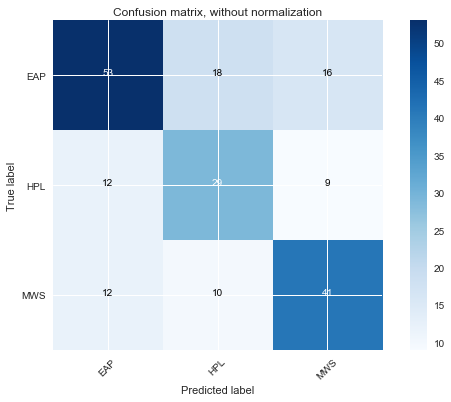

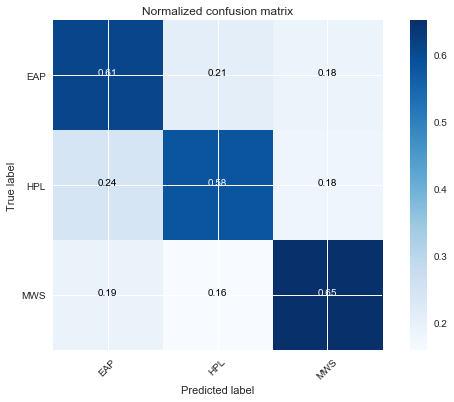

In [137]:

pipeline = winner[2]
pipeline.fit(X_train, Y_train)
Y_pred = pipeline.predict(X_test)
y_prob_output = pipeline.predict_proba(X_test)  
final_plot_confusion(Y_test, Y_pred) 



<h2>Submission to Kaggle</h2>
First, we must adapt the features building functions.

<h3>Loading Test Set</h3>

In [138]:
#loading of test dataset
test = pd.read_csv("test.csv")

test.text= test.text.astype(str)

test = test[0:30] #for coding 
#construction of the feature vectors

In [139]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
id      30 non-null object
text    30 non-null object
dtypes: object(2)
memory usage: 560.0+ bytes


<h3>Adapting building functions</h3>

In [140]:
#this function works for n-grams of characters, pos tokens or words

#first argument is the n in n-gram
#analysis type is 'word', 'char', token_pos', ...

def counting_a_final(a, analysis):
    
    df_train = train.copy()
    df_test  = test.copy()
    
    #if we are counting words:
    if analysis == "word" or analysis == "char": 
        
        #check the CountVectorizer doc
        #we create a Countvectorizer, called bow_transformer
        bow_transformer = CountVectorizer(analyzer = analysis,
                                      lowercase = True, #we don't care about place in sentence
                                      ngram_range = (a, a),
                                      stop_words='english')

        #we use bow_transformer to fit and transform our training set
        messages_bow = bow_transformer.fit_transform(df_train['text'])
        
        #we use bow_transformer to transform our test set. 
        #We do not need to train if first because the fitting would recompute the idf, we don't want that
        messages_bow_test = bow_transformer.transform(df_test['text'])
    
    #if we are counting POS:    
    elif analysis == "token_pos":
        
        #this is the punctuation we want to keep
        punctuation = r"(?u)\b\w\w+\b|!|\?|\"|\'|\.|\,|\;|\:|\$|\(|\)|\--|\&|\``|\'' + PRP$ + WP$"
        #we create a Countvectorizer, called bow_transformer
        bow_transformer = CountVectorizer(analyzer = 'word',
                                          lowercase = False, #we DO care about place in sentence
                                          ngram_range = (a, a),
                                          token_pattern =  punctuation, #we DO care about punctuation
                                          stop_words='english')
        
        #we use the transform_tag function to transform the sentence in a sentence of pos tag        
        #we use bow_transformer to fit and transform our training set
        messages_bow = bow_transformer.fit_transform(df_train['text'].apply(transform_tag))
        #we use bow_transformer to transform our test set
        #We do not need to train if first because the fitting would recompute the idf, we don't want that
        messages_bow_test = bow_transformer.transform(df_test['text'].apply(transform_tag))

        
    #this is the DataFrame Concerning the regular counting of words
    
    ##What does this do?
    """
    messages_tfidf = TfidfTransformer().fit_transform(messages_bow)
    messages_tfidf_test = TfidfTransformer().transform(messages_bow_test)
    names = bow_transformer.get_feature_names()
    
    """
    tfidf_transformer = TfidfTransformer().fit(messages_bow)
    messages_tfidf = tfidf_transformer.transform(messages_bow)
    messages_tfidf_test = tfidf_transformer.transform(messages_bow_test)
    
    names = bow_transformer.get_feature_names()
     
    
    
    
    return (messages_tfidf, names, messages_tfidf_test)


In [141]:
def build_bag_a_final(a,  analysis, top_n = 50):
    df_bag = train.copy()
    df_bag_test = test.copy()
    
    build = counting_a_final(a, analysis)
    
    alpha = top_feats_by_class(build[0], df_bag.author, build[1], top_n = top_n)

    a = list(alpha[0].feature.values)
    b = list(alpha[1].feature.values)
    c = list(alpha[2].feature.values)
    bag = set(a + b + c)


    for w in bag:
        vec = build[0][:, build[1].index(w)].toarray()
        df_bag[w] = vec

        vec_test = build[2][:, build[1].index(w)].toarray()
        df_bag_test[w] = vec_test
        
    df_bag = df_bag.drop(labels = ['text','author'], axis = 1)
    df_bag_test = df_bag_test.drop(labels = ['text'], axis = 1)

        
    return df_bag, df_bag_test

In [142]:
#we build here the 2 feature datasets (one for train, one for test)
#should be adapted when we'll add features

def build_bunch_train(dataframe):
    list_df_tr = [build_meta2(dataframe),
                  build_meta1(dataframe),
                  build_sensi(dataframe),
                  build_bag_a_final(1,'word')[0],
                  build_bag_a_final(2,'word')[0],
                  build_bag_a_final(3,'word')[0],
                  build_bag_a_final(1,'char')[0],
                  build_bag_a_final(2,'char')[0],
                  build_bag_a_final(3,'char')[0],
                  build_bag_a_final(4,'char')[0],
                  build_bag_a_final(5,'char')[0],
                  build_bag_a_final(6,'char')[0],
                  build_bag_a_final(7,'char')[0],
                  build_bag_a_final(1, 'token_pos')[0],
                  build_bag_a_final(2, 'token_pos')[0],
                  build_bag_a_final(3, 'token_pos')[0],
                  build_bag_a_final(4, 'token_pos')[0],
                  build_bag_a_final(5, 'token_pos')[0],
                  build_bag_a_final(6, 'token_pos')[0],
                  first_word(dataframe),
#                   twofirst_word(dataframe),
                  last_word(dataframe),
#                   twolast_word(dataframe),
                  language(dataframe),
                  emotions(dataframe)
              ]
    bunch = pd.merge(list_df_tr[0], list_df_tr[1])
    
    for i in range(2, len(list_df_tr)):
        alpha = bunch
        bunch = pd.merge(alpha, list_df_tr[i], on = 'id')
    
    return bunch

#build_bunch_train(train)

In [143]:
def build_bunch_test(dataframe):
    list_df_ts = [build_meta2(dataframe),
                  build_meta1(dataframe),
                  build_sensi(dataframe),
                  build_bag_a_final(1,'word')[1],
                  build_bag_a_final(2,'word')[1],
                  build_bag_a_final(3,'word')[1],

                  build_bag_a_final(1,'char')[1],
                  build_bag_a_final(2,'char')[1],
                  build_bag_a_final(3,'char')[1],
                  build_bag_a_final(4,'char')[1],
                  build_bag_a_final(5,'char')[1],
                  build_bag_a_final(6,'char')[1],
                  build_bag_a_final(7,'char')[1],
               
                  build_bag_a_final(1, 'token_pos')[1],
                  build_bag_a_final(2, 'token_pos')[1],
                  build_bag_a_final(3, 'token_pos')[1],
                  build_bag_a_final(4, 'token_pos')[1],
                  build_bag_a_final(5, 'token_pos')[1],
                  build_bag_a_final(6, 'token_pos')[1],
                  first_word(dataframe),
#                   twofirst_word(dataframe),
                  last_word(dataframe),
#                   twolast_word(dataframe),
                  language(dataframe),
                  emotions(dataframe)
                 ]


    bunch = pd.merge(list_df_ts[0], list_df_ts[1])
    
    for i in range(2, len(list_df_ts)):
        bunch = pd.merge(bunch, list_df_ts[i], on = 'id')
    
    return bunch

#build_bunch_test(test)

<h3>Training over all the Training Dataset</h3>

In [144]:
# load dataset

names = author_list
dataframe_train = build_normalization(build_bunch_train(train))
dataframe_train.to_csv('final_dataframe_train')
array = dataframe_train.values
X_train = array[:,3:]
Y_train = array[:,2]

names = author_list
dataframe_test = build_normalization(build_bunch_test(test))
dataframe_test.to_csv('final_dataframe_train')
array = dataframe_test.values
X_test = array[:,2:]
Y_test = array[:,2]

/Users/Selim/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [149]:
print(np.shape(X_train))
print(np.shape(X_test))

(800, 1930)
(30, 1930)


In [150]:
#training
pipeline = winner[2]
pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('S_PCA_10', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('NB', GaussianNB(priors=None))])

<h3>Generating the probabilities</h3>

In [151]:
Y_pred = pipeline.predict(X_test)
y_prob_output = pipeline.predict_proba(X_test)

In [152]:
print(y_prob_output)

[[9.99219e-001 8.21190e-064 7.81277e-004]
 [1.00000e+000 0.00000e+000 1.56510e-063]
 ...
 [1.00000e+000 2.96462e-265 3.05970e-023]
 [1.00000e+000 0.00000e+000 6.63588e-049]]


<h3>CSV File</h3>

In [153]:
y_prob_output[:,0]

array([0.99922, 1.     , 1.     , 1.     , 0.00717, 1.     , 0.7221 ,
       1.     , 1.     , 0.38741, 1.     , 1.     , 1.     , 1.     ,
       0.92577, 0.14795, 0.99416, 1.     , 0.99997, 0.99988, 0.16933,
       1.     , 0.98148, 0.93144, 1.     , 0.90796, 0.99999, 1.     ,
       1.     , 1.     ])

In [154]:
df_submit = pd.DataFrame(columns = ['id',"EAP","HPL","MWS"])
df_submit['id'] = test['id']
df_submit['EAP'] = y_prob_output[:,0]
df_submit['HPL'] = y_prob_output[:,1]
df_submit['MWS'] = y_prob_output[:,2]
df_submit

,id,EAP,HPL,MWS
0,id02310,0.999219,8.211904e-64,7.812766e-04
1,id24541,1.000000,0.000000e+00,1.565101e-63
2,id00134,1.000000,3.147887e-186,3.464597e-16
3,id27757,1.000000,2.169087e-264,3.378322e-34
4,id04081,0.007169,2.869660e-13,9.928307e-01
5,id27337,1.000000,3.101557e-213,1.226470e-18
6,id24265,0.722105,1.025132e-22,2.778954e-01
7,id25917,0.999996,1.616491e-118,4.207624e-06
8,id04951,1.000000,1.669854e-159,3.338768e-20
9,id14549,0.387405,5.602076e-07,6.125944e-01


In [155]:
df_submit.to_csv('submission.csv', index=False)